In [1]:
# Import libraries
import ast
import csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
import glob, os
import re
from tqdm import tqdm

# To make the plot in the notebook and not in an extra window
%matplotlib notebook 

# Implement error messages (Default should be True)
error_on_missing_timestamps = False
error_on_time_light_mismatch = False
error_on_time_behavior_mismatch = False
error_on_missing_behaviors = False
error_on_invalid_behavior_range = False

Part 1: Generation of single data frame per sample, including behavior annotation, timestamp and dff

In [2]:
#Open multiple .csv from single directory. Define existing behaviors. Define sample_ID and experiment_ID.
# Chris's FRAN is zero based!!, whereas old annotations are 1 based
#directory for behavior data

behavior_directories = [r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_cl_A4/',
                        r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_cl_A9/',
                        r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_ol/',
                        r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_stim_artefact/'
                       ] 

behavior_files = []
for d in behavior_directories:
    behavior_files.extend(
        glob.glob(os.path.join(d, "*.csv"))) #join pathname with filename, 

# Behavior columns available in CSV files
available_behaviors = ('fw', 'bw', 'stim', 'hunch', 'turn', 'other', 'HP', 'left turn', 'right turn')

# Regular expression (define the expression filenames are searched for)
# '.' single character, matched everything, '*' 0>> occurences, '/' path delimiter, '\d' 0-9 digit,
# '+' 1>> occurences, 'L' here character from filename
# () outcome here: 2 groups, useful for extraction
# [] optional list, eg 1 --> 1
# ? character non or once 

# Behavior reg-ex (regular expression)
behavior_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-behavior-(.+).csv')

# Function: readall_behavior iterates through all csv (sorted) 
# and appends the files into the list (ls) and returns dictionary
def readall_behavior(all_files, printit=False):
    data = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # exp_id = DETAIL: several measurements of same sample 
        # (cl (closeloop, RGECO/ Chronos), ol (openloop, RGECO/ Chronos), 
        # blocks (Raghav: GCaMP/Chrimson))
        # Larva ID: YY-MM-DDLX
        # Look for filename_components, which are true for pattern
        match = behavior_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        #define filename_components sample_id (first group), and exp_id (sec group)
        part_sample_id, _, exp_id = filename_components         
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        df = pd.read_csv(filename, index_col=None, header=0, delimiter = ';')
        df.fillna(0, inplace=True) #replace NaN with zero
        df['sample_id'] = sample_id  #add sample_id column
        df['exp_id'] = exp_id #add exp_id column
        data[sample_id] = df
        #Count 'True' for each column ('behavior') in each single behavior.csv)
        #print(filename, df[df == 1].count()) 
        #print(df)
    return data

behavior_data = readall_behavior(behavior_files)
#print(behavior_data['17-11-06L2-cl'])



In [3]:
# Frequency of each behavior in all imported behavior.csv by using the returned 'ls' from 
# the function readAll: concatenate the 'behavior_files' (global variable). 'True' for each 
# column ('behavior_type') in the concatenated file (df_behavior).
# Sorting has to be = False (warning message without 'sort')
df_behavior = pd.concat(behavior_data.values(), axis = 0, ignore_index = True, sort = False) #add sorting
print(df_behavior[df_behavior == 1].count()) 

START            11
END               0
fw             5108
bw              918
stim            353
hunch           440
turn           2169
other           185
HP              795
left turn      1088
right turn     1081
sample_id         0
exp_id            0
Unnamed: 11       0
dtype: int64


In [4]:
# Import and merge fluorescence data: Several LM files for the same sample_id exists, but differ in cell_id).
# List of LM data with two extra columns: sample_id and cell_id
# Open LM files from different directories
lightmicroscope_directories = [r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/Basin_traces/', 
                               r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/Handle-like_Traces',
                               r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/a00c_traces',
                               r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/candidate_neuron_traces'
                              ] 

# Iterate through LM data and extend files in a list from within and between directory and 
# build a list of files from all directories
# (Note: append would 'extend' lists and not single files)
lightmicroscope_files = []
for d in lightmicroscope_directories:
    lightmicroscope_files.extend(
        glob.glob(os.path.join(d, "*.csv"))) #join pathname with filename

# Lightmicroscopic data reg-ex (regular expression)
lightmicroscope_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-(.*)-(.*).csv')

# Function: readall_lm iterates through all LM_csv (sorted) 
# and returns a dictionary{key:value} 
# samples = {sample_id:cell-id}
def readall_lm(all_files):
    samples = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # Larva ID: YY-MM-DDLX, DETAIL = cell_id
        # Look for filename_components, which are true for pattern
        match = lightmicroscope_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, cell_id, exp_id = filename_components
        
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        # Read LM.files 
        df = pd.read_csv(filename, index_col=None, header=0, delimiter = ',')
        # Replace NaN with zero
        df.fillna(0, inplace=True)
        
        # Add cellname to each column as prefix
        # lambda is a non defined function (longer version: def lambda(x):)
        # Rename of columns after the format cell_id, name) eg: Basin A9
        # inplace = True: column names are overwritten (if False: new dataframe)
        df.rename(lambda x: '{}_{}'.format(cell_id, x), axis = 'columns', inplace = True)
        # Get the sample_id (key) from the dictionary? to make a list [sample_cells] and 
        # if sample_id exists, append the list
        # if sample_id does not exists, start a new list
        # reminder: there can be several cell_id per sample_id
        sample_cells = samples.get(sample_id)
        if not sample_cells:
            samples[sample_id] = sample_cells = {
                'data': [],
                'exp_id': exp_id,
            }
        sample_cells['data'].append(df)
        
    return samples

lm_samples = readall_lm(lightmicroscope_files)

# New dictionary: lm_data{} to build a single dataframe with all cell_ids combined 
# for a single sample. Iterate over dict from same sample in one dataframe. 
# df.items iterate over pairs and build a list

lm_data = {}

# Iterate over all light samples and merge all found files
# for each sample into a single data frame (per sample)
for sample_id, sample_info in lm_samples.items():
    cells_dataframes = sample_info['data']
    #check if number of cells >= 1
    if not cells_dataframes:
        raise ValueError('No cells found for sample {}'.format(sample_id))
    #first element in the list
    lm_df = None

    #iteration through other df
    for cdf in cells_dataframes:
        if lm_df is None:
            lm_df = cdf
        else:
            if len(lm_df.index) != len(cdf.index):
                raise ValueError('Data frame frame to merge has not same row count as target', sample_id)
            lm_df = pd.merge(lm_df, cdf, left_index = True, right_index = True)
            
    lm_df['sample_id'] = sample_id  #add sample_id column
    lm_df['exp_id'] = sample_info['exp_id']
    lm_data[sample_id] = lm_df
#print(list(lm_data.keys()))

In [5]:
# Import txt-files from of the absolute time/frame from the Ca-imaging (lm-data). 
# All txt-files have to be transposed, which is a memory intensive step. After the 
# data are complete, the transposed files should be exported (ToDo). Time-data are 
# combined with sample-ID and experiment-ID.

timelapse_directory =(r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/timelapse/') 
timelapse_files = glob.glob(os.path.join(timelapse_directory, "*.txt")) #join pathname with filename

# Behavior reg-ex (regular expression)
time_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-time-(.+).txt')

# Function: readall_timelapse iterates through all txt (sorted) and appends the 
# files into the dict (data) and returns ls
def readall_time(all_files, printit=False):
    data = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # exp_id = DETAIL: several measurements of same sample (cl (closeloop), ol (openloop), blocks (Raghav))
        # Larva ID: YY-MM-DDLX
        #look for filename_components, which are true for pattern
        match = time_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, exp_id = filename_components #define filename_components sample_id (first group), and exp_id (sec group)  
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        df = pd.read_csv(filename, header=1, index_col=None, delim_whitespace = True)
        df = df.T #transposing because read_csv imports as row
        df = df.reset_index() #transpose function sets data as index
        df.rename(columns={'index':'time'}, inplace=True) #rename reset index column to time
        df['time'] = df.time.astype(float)
        data[sample_id] = df
        
    return data

In [6]:
# Keep in mind that some of the files has to be changed because of the discrepancy in timestamps
timelapse_cache = 'timelapse.cache'

try:
    with open(timelapse_cache, 'r') as timelapse_cache_file:
        # TODO
        cache_data = timelapse_cache_file.read()
        time_data = ast.literal_eval(cache_data)
except FileNotFoundError as e:
    print('No cache file found, recomputing')
    # No cache file found, recompute
    time_data = readall_time(timelapse_files)
    # Write cache
    

No cache file found, recomputing


In [7]:
sample_data = {}

# Time data are merged into light data and checked if number length of lm = timestamp.  
# Due to technical conditions, some time.txt-file have too many or not enough time data compared
# to the corresponding LM data. The discrepancy is fixed by either dropping the extra timepoints or 
# by taking the average of the difference between each timepoint and extend the dataframe. 
# The first 10 timepoints are not included to account for instability of the microscope in 
# the beginning due to the moving parts. 
# Maximal difference between timepoints fyi.

for sample_id, sample_df in lm_data.items():
    # Add time stamps to data frame of current sample by merging
    # The time data frame for the current sample, which is expected
    # to match the light data (based on index).
    timestamp_df = time_data.get(sample_id)
    if timestamp_df is None:
        msg = '{}: could not find timestamp data for sample'.format(sample_id)
        if error_on_missing_timestamps:
            raise ValueError(msg)
        # Ignore, if missing data shouldn't cancel the whole process.
        print(msg)
        continue
        
    n_timestamps = len(timestamp_df)
    n_lightdata = len(sample_df)
    
    # The timestamp and light recordings are done by different systems.
    # This can cause the existence of additional time points/ or missing time points in a
    # dataset, which will be filtered out in the merge operation below.
    if n_lightdata != n_timestamps:
        msg = '{}: time data ({} entries) doesn\'t match light data ({} entries)'.format(
                sample_id, n_timestamps, n_lightdata)
        if error_on_time_light_mismatch:
            raise ValueError(msg)
        print(msg)
        diffs = np.diff(timestamp_df['time'])[10:] #from 10th row onwards
        diffs_avg = diffs.mean(axis=0)
        #diff between timedata and lightdata
        missing_data = len(sample_df) - len(timestamp_df)
        
        #add 'diffs_avg' to fill in missing_timedata
        if missing_data > 0:
            last_valid_index = len(timestamp_df) - 1
            last_timestamp = timestamp_df.iloc[last_valid_index]['time']
            if pd.isna(last_timestamp):
                raise ValueError('Unexpected last valid timestamp for sample {} at index {}'.format(
                        sample_id, last_valid_index))
            for i in range(0, missing_data):
                last_valid_index += 1
                timestamp_df.loc[last_valid_index] = timestamp_df.iloc[last_valid_index - 1]['time'] + diffs_avg
        elif missing_data < 0:
            drop_start = len(timestamp_df) + missing_data
            drop_end = len(timestamp_df)
            timestamp_df.drop(list(range(drop_start, drop_end)))

    # Merge timedata into light data
    # Use an 'inner' join/merge to exclude time points that don't have matching light data.
    new_sample_df = pd.merge(sample_df, timestamp_df, left_index = True, right_index = True, how='inner')
    
    # Store newly created data frame for sample (dictionary)
    sample_data[sample_id] = new_sample_df
    
print('Matched {} light data sets with their respective time points'.format(len(sample_data)))

# Max.diffs for timestamps
diffs = np.diff(timestamp_df['time'])[10:] #from 10th row onwards
mx = diffs.max()
#print(mx)

17-08-24L5-cl: time data (6686 entries) doesn't match light data (6685 entries)
17-08-26L1-cl: time data (6990 entries) doesn't match light data (6989 entries)
17-08-27L2-cl: time data (6470 entries) doesn't match light data (6469 entries)
17-08-28L3-cl: time data (6228 entries) doesn't match light data (6225 entries)
17-08-29L2-cl: time data (6817 entries) doesn't match light data (6805 entries)
17-11-03L7-cl: time data (1399 entries) doesn't match light data (2657 entries)
17-11-04L1-cl: time data (6325 entries) doesn't match light data (6324 entries)
17-11-06L1-cl: time data (1923 entries) doesn't match light data (6493 entries)
17-11-08L3-cl: time data (3240 entries) doesn't match light data (6474 entries)
17-11-26L1-cl: time data (6487 entries) doesn't match light data (6469 entries)
17-11-29L3-cl: time data (6567 entries) doesn't match light data (6561 entries)
17-11-30L2-cl: time data (6640 entries) doesn't match light data (6396 entries)
Matched 75 light data sets with their re

In [8]:
# Combine behavior data with light data into a single data frame
# per sample ID. To do so, add behavior data to light data frames,
# because the light data is already organizes by frame. To accomodate
# frame ranges without an behavior data, a column named "quiet" is
# added which is True in these cases and False otherwise. Additionally,
# for each behavior column, a behavior start and end column as well as
# an overlap column is added so that parallel and successive behaviors
# of the same type can be differentiated.

for sample_id, sample_df in sample_data.items():
    sample_behavior = behavior_data.get(sample_id)
    if sample_behavior is None:
        msg = 'Could not find behavior data for sample "{}"'.format(sample_id)
        if error_on_missing_behaviors:
            raise ValueError(msg)
        print(msg)
        continue

    # Add extra columns for behavior
    for behavior in available_behaviors:
        sample_df[behavior] = False
        sample_df['{}_start'.format(behavior)] = False
        sample_df['{}_end'.format(behavior)] = False
        sample_df['{}_overlap'.format(behavior)] = False
    
    # Add 'quiet' column. Set it initially to True and mark frames
    # with actual behavior as quiet = False.
    sample_df['quiet'] = True
    
    n_light_entries = len(sample_df)

    # Iterate over behavior data and add data to target data frame
    for i, row in sample_behavior.iterrows():
        # Start and end are 1-based, make them 0-based
        start = int(row['START'])
        end = int(row['END'])
        
        if type(row['START']) == str:
            print(sample_id)
            print(start, end)
        
        if start >= end:
            msg = "{}: start ({}) needs to be strictly smaller than end ({})".format(sample_id, start, end)
            if error_on_invalid_behavior_range:
                raise ValueError(msg)
            print(msg)
            continue
        
        # Make sure we capture start/end times that are a fractional number.
        if row['START'] - start > 0 or row['END'] - end > 0:
            raise ValueError('{}: start and end frame number can\'t contain fractions'.format(sample_id))
            
        # Ignore behavior entries with an end frame higher than available light data.
        # The behavior data is one-based, which is why a strict larger than test should
        # be correct.
        if end > n_light_entries:
            msg = 'Sample: {} - Behavior row with range {}-{} exceeds light time points ({}): {}'.format(
                sample_id, start, end, n_light_entries, row)
            if error_on_time_behavior_mismatch:
                raise ValueError(msg)
            print(msg)
            continue
            
        # Find behavior observed in row
        observed_behaviors = []
        for behavior in available_behaviors:
            if row[behavior]:
                observed_behaviors.append(behavior)
        
        # We assume that not more than two behaviors are observed at the same time
        if len(observed_behaviors) > 2:
            raise ValueError('Found multiple behaviors in row {} of sample {}'.format(i, sample_id))
        
        # Add observed behavior information to target data frames in all
        # rows in behavior range.
        for b in observed_behaviors:
            # Iterate over frames valid for current behavior. Every valid
            # frame is mapped into the canonical (light/cell) data frame,
            # which is 0-indexed.
            for j in range(start, end + 1):
                # Behavior ranges are 1-indexed
                current_frame = j - 1
                # If the current behavior has already been observed at this frame,
                # set overlap to True, because we are about to mark this behavior
                # again as observed for this frame.
                if sample_df.at[current_frame, b]:
                    sample_df.at[current_frame, '{}_overlap'.format(b)] = True
                else:
                    sample_df.at[current_frame, b] = True
                
                # Mark this row as not quiet, because we observed
                # a behavior in the current frame.
                sample_df.at[current_frame, 'quiet'] = False

            sample_df.at[start - 1, '{}_start'.format(b)] = True
            sample_df.at[end - 1, '{}_end'.format(b)] = True
            
    # Mark quiet ranges with _start, _end and _overlap. By definion,
    # quiet_overlap is always False.
    sample_df['quiet_start'] = False
    sample_df['quiet_end'] = False
    sample_df['quiet_overlap'] = False
    last_sample_idx = n_light_entries - 1
    for i, row in sample_df.iterrows():
        sample_df.at[i, 'quiet_start'] = row['quiet'] and (i == 0 or not sample_df.at[i - 1, 'quiet'])
        sample_df.at[i, 'quiet_end'] = row['quiet'] and (i == last_sample_idx or not sample_df.at[i + 1, 'quiet'])

Part 2: Data-analysis

In [9]:
# Define a class with sample_id, cell_type, event_name and filter_pattern

class CellTraceConfig:
    
    def __init__(self, sample_id, cell_type, event_name, filter_pattern=None):
        self.sample_id = sample_id
        self.cell_type = cell_type
        self.event_name = event_name
        self.filter_pattern = filter_pattern
        
    def get_filter_regex(self):
        filter_regex = '^{}_'.format(self.cell_type)
        if self.filter_pattern:
            filter_regex += '.*{}.*'.format(self.filter_pattern)
        return filter_regex
    
    def get_event_start_col(self):
        return '{}_start'.format(self.event_name)

    def add_event_time_points_to_plot(self, source_df, plot):
        for idx, row in source_df.iterrows():
            plot.annotate(self.event_name, xy=(row['time'], 1))
            plt.axvline(row['time'], color='k', linestyle='-')  
            
# Define a class with sample_id, cell_type, event_time and filter_pattern (for behavioral_transitions)
# Put '' [empty string] if you dont want any cell type

class CellTransConfig:
    
    def __init__(self, sample_id, cell_type, event_time, filter_pattern=None):
        self.sample_id = sample_id
        self.cell_type = cell_type
        self.event_time = event_time
        self.filter_pattern = filter_pattern
        
    def get_filter_regex(self):
        if self.cell_type is None:
            cell_str = r"[a-zA-Z0-9]+"
        else:
            cell_str = self.cell_type
            
        filter_regex = '^{}_'.format(cell_str)
        if self.filter_pattern:
            filter_regex += '.*{}.*'.format(self.filter_pattern)
        return filter_regex
    
    
    
# Define a class for filtering after behavioral_transitions for either only cell_type or filter_pattern or both.
# For example to average not only over all A00cs but all A00c_midL.

class DataFilter():
    def __init__(self, cell=None, pattern=None):
        self.cell = cell if cell is not None else '.*' # Makes argument optional
        self.pattern = pattern if pattern is not None else '.*' # Makes argument optional
        
    def get_cell_filter_regex(self):
        filter_regex = '.*_{}_.*_.*'.format(self.cell)
        return filter_regex
    
    def get_pattern_filter_regex(self):
        filter_regex = '.*_.*_{}_.*'.format(self.pattern)
        return filter_regex
    
    def get_cellpattern_filter_regex(self):
        filter_regex = '.*_{}_{}_.*'.format(self.cell, self.pattern)
        
    def __str__(self):
        return "{}_{}".format(self.cell, self.pattern)   
    
    
# Define class to group the columns after cell_type/ pattern or both using the class Datafilter

class TransitionGrouper:
    def __init__(self, transitions_df):
        self.transitions_df = transitions_df
        
        sample_ids, cells, patterns, _ = zip(*[column.split("_") for column in self.transitions_df.columns])
        
        self.sample_ids = sorted(set(sample_ids))
        self.cells = sorted(set(cells))
        self.patterns = sorted(set(patterns))
        
    def get_regex(self, cell_name=None, pattern=None):
        data_filter = DataFilter(cell=cell_name, pattern=pattern)
        if cell_name is not None and pattern is None:
            return data_filter, data_filter.get_cell_filter_regex()
        if cell_name is not None and pattern is not None:
            return data_filter, data_filter.get_cellpattern_filter_regex()
        if cell_name is None and pattern is not None:
            return data_filter, data_filter.get_pattern_filter_regex()
        raise ValueError("Both cell_name and pattern are None! :(")
    
    def group_cells(self):
        output = dict()
        for cell_name in self.cells:
            data_filter, regex = self.get_regex(cell_name)
            cell_df = self.transitions_df.filter(regex=regex)
            output[cell_name] = (str(data_filter), cell_df)
        return output
    
    def group_patterns(self):
        output = dict()
        for pattern in self.patterns:
            data_filter, regex = self.get_regex(pattern=pattern)
            pattern_df = self.transitions_df.filter(regex=regex)
            output[pattern] = (str(data_filter), pattern_df)
        return output
    
    def group_cellpattern(self):
        output = dict()
        for cell_name, pattern in itertools.product(self.cells, self.patterns):
            data_filter, regex = self.get_regex(cell_name, pattern)
            cellpattern_df = self.transitions_df.filter(regex=regex)
            output[(cell_name, pattern)] = (str(data_filter), cellpattern_df)
        return output

In [10]:
# Load single samples with specific filter pattern
cell_trace_configs = [
    CellTraceConfig('17-08-26L6-cl', 'candidate', 'stim'),
    #CellTraceConfig('17-08-26L5-cl', 'A00c', 'stim', 'mid')
]

# Load all samples with specific filter pattern
'''
cell_trace_configs = [
    CellTraceConfig(name,'A00c', 'fw') for name in lm_data]
'''

all_events = [] #List of events, with raw dff data (no interpolation or other 
                #processing done at this point). Sample_id is added to the cell name. 

for ctc in cell_trace_configs:
    #print(sample_df.keys)
    #break
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
    # Extract columns matching our cell type and the optional filter pattern.
    # Pandas' filter() operations works on columns for DataFrames by default.
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    #print(ctc.sample_id, cell_subset_df)   
    # Get rows where current event starts.
    event_df = sample_df[sample_df.loc[:,ctc.get_event_start_col()]]
    # Gives the timestamp for the event_df (start)
    for idx, row in event_df.iterrows():
        print('TP of {} ='.format(ctc.event_name), row['time'])
        
    # Extract for specific time window and align several events. 
    # Define timepoints pre and post an event (event_df). 
    # This works for single sample or multiple samples aligned 
    # Note: In cell_subset_df, time was set to index, because for the previous avg calculation 
    # Add index and time = column

    # Set the window range left and right from the event
    left_half_window_size = 10.0 #in seconds
    right_half_window_size = 50.0

    # Event_df defined in pargraph before 
    windows = []
    n_behavior = 0
    for i,row in event_df.iterrows():
        n_behavior += 1
        window_start = row['time'] - left_half_window_size
        window_end = row['time'] + right_half_window_size
        
        # Get subset of rows between window_start and window_end       
        event = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]
        # Normalizing the data to align on beginning of selected
        # behavior (event_df = Zero) by substracting events in window
        # around start of event of interest from start of event interest.
        # Note: using ":" in event.loc[] will select "all rows" in our window.
        event.loc[:, 'time'] = event['time'] - row['time']

        # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
        event.rename(lambda x: '{}_{}_{}'.format(ctc.sample_id, x, n_behavior), 
                     axis = 'columns', inplace = True) 

        # Rename time collum to time
        event.rename(columns={ event.columns[0]: 'time' }, inplace = True) 
        all_events.append(event) # Append a list with all event
        
        #Round (NR)
        #decimals = 1    
        #event['time'] = event['time'].apply(lambda x: round(x, decimals))
        
        
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_df = all_events.pop(0)
for right_df in all_events:
    all_df = pd.merge_ordered(all_df, right_df, on="time", how="outer")

# Resets the index as time and drops time column (sollte spaeter kommen)
all_df.index = all_df["time"]
del all_df["time"]        
#print(all_df)

# Index intepolation (linear interpolatione not on all_df, because index [=time] is not eaqually distributed)
int_all_df = all_df.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')
#print(int_all_df)


TP of stim = 48.717
TP of stim = 280.751
TP of stim = 505.412
TP of stim = 729.754
TP of stim = 959.865
TP of stim = 1183.885
TP of stim = 1408.227
TP of stim = 1897.292
TP of stim = 2121.313


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [11]:
    # Single sample analysis
    # For single sample over the whole experimental time
    # Calculate min, max, avg, stddev, sem from cell_subset_df (defined earlier)
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    del cell_subset_df['time'] # delete time_column
    cell_subset_df.index.name = None # delete index name
    cell_avg_df = cell_subset_df.mean(axis=1)
    cell_min_df = cell_subset_df.min(axis=1)
    cell_max_df = cell_subset_df.max(axis=1)
    # Standard deviation (distribution)
    cell_std_df = cell_subset_df.std(axis = 1)
    #standard error of mean
    cell_sem_df = cell_subset_df.sem(axis = 1)
    #print(ctc.sample_id, cell_avg_df) 


# For single or multiple sample, aligned for certain event. Interpolated data used!
# Averaged all events and all cells pro timepoint
# Average for specific cell type filter-pattern (see below)
all_cell_avg_df = int_all_df.mean(axis=1) 
all_cell_min_df = int_all_df.min(axis=1)
all_cell_max_df = int_all_df.max(axis=1)
# Standard deviation (distribution)
all_cell_std_df = int_all_df.std(axis = 1)
#standard error of mean
all_cell_sem_df = int_all_df.sem(axis = 1)
#print(all_cell_avg_df) 

"\n# Avg, min, max, std-dev for multiple cells in single sample over whole time\nsub2 = fig.add_subplot(212)#212\nctc.add_event_time_points_to_plot(event_df, sub2)\ncell_avg_df.plot(ax=sub2, color = 'g', label = ctc.cell_type, linewidth=1)\ncell_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)\ncell_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)\n#cell_avg_df.plot.line(yerr=cell_std_df, ax=sub2, color = 'r', alpha = 0.1)\n#cell_avg_df.plot.line(yerr=cell_sem_df, ax=sub2, color = 'c', alpha = 0.1)\nlayout_plot(sub2)\n"

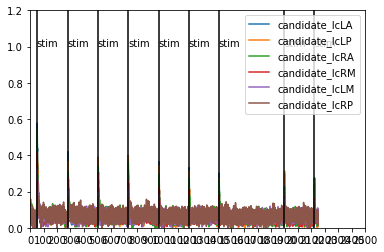

In [12]:
# Plotting - single sample 
def layout_plot(plot, tick_spacing=100, fov=(0, 2500, 0, 1.2), legend=True): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

# Get rows where current event is active and draw a vertical 
# line to indicate the event in the plot
event_df = sample_df[sample_df.loc[:,ctc.get_event_start_col()] == 1]
fig = plt.figure()
fig.set_facecolor("white")

# Plot all cells from cell_subset_df over entire time (specified in Cell_Trace_Config).
sub1 = fig.add_subplot(111) #211
cell_subset_df.plot(ax=sub1)
ctc.add_event_time_points_to_plot(event_df, sub1)
layout_plot(sub1)
'''
# Avg, min, max, std-dev for multiple cells in single sample over whole time
sub2 = fig.add_subplot(212)#212
ctc.add_event_time_points_to_plot(event_df, sub2)
cell_avg_df.plot(ax=sub2, color = 'g', label = ctc.cell_type, linewidth=1)
cell_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
cell_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#cell_avg_df.plot.line(yerr=cell_std_df, ax=sub2, color = 'r', alpha = 0.1)
#cell_avg_df.plot.line(yerr=cell_sem_df, ax=sub2, color = 'c', alpha = 0.1)
layout_plot(sub2)
'''

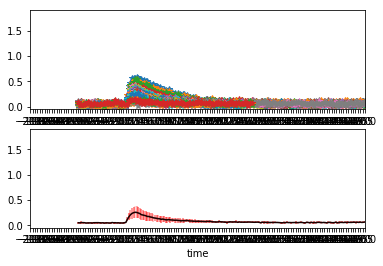

In [13]:
# Note: HERE FOR PLOTTING THE ALIGNED EVENT, INDEPENDENT OF PRO AND / OR POST_EVENT
# Plotting for multi-events (all_df) (raw_dff_data)
# If a dataframe with NANs is plotted, use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=0.5, fov=(-20, 50, -0.05, 1.9), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

# Plot all cells from all_df, aligned at zero for event_start, specified in Cell_Trace_Config.
sub1 = fig.add_subplot(211)
all_df.plot(ax=sub1, marker = '*', label = ctc.cell_type)
aligned_layout_plot(sub1)

sub2 = fig.add_subplot(212)
all_cell_avg_df.plot(ax=sub2, color = 'k', label = ctc.cell_type) #use interpolated df to calculate average...
#all_cell_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#all_cell_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
all_cell_avg_df.plot.line(yerr=all_cell_std_df, ax=sub2, color = 'r', alpha = 0.1)
#all_cell_avg_df.plot.line(yerr=all_cell_sem_df, ax=sub2, color = 'c', alpha = 0.1)
aligned_layout_plot(sub2)


The following part extract the information about behavior transition under certain limitation:
1) Find transition between two different! behaviors, within a max_delay.
2) Find 2 transition between two different! behaviors with intersection: first event end = second event start, within a max_delay.
3) Find transition between two identical! behaviors, within a max_delay.

In [15]:
class PostBehaviorTransition:
    
    def __init__(self, sample_id, event, post_event, max_delay=0):
        self.sample_id = sample_id
        self.post_event = post_event
        self.event = event
        self.max_delay = max_delay

def find_behavior_before(sample_id, sample_df, first_event, second_event, 
                         max_delay=0, 
                         first_event_duration=None, 
                         second_event_duration=None):
    """For the data frame of a single sample <df>, find all behaviors
    of type <first_event> that is followed by the event <second_event>,
    separated by <max_delay> time. The end of <second_event> is expected
    to happen strictly after the end of <first_event>. The start time
    of <second_event> however can overlap with the end time of <first_event>.
    In this case, the time difference is negative, and still smaller than
    <max_delay>. The start time of <second_event> can be before, at or after the
    end of <first_event>.
    """
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    second_event_overlap_col = '{}_overlap'.format(second_event)
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    
    for i, row in sample_df.iterrows():
        # Look for start of second behavior and remember its time.
        if row[second_event_start_col] and not row[second_event_overlap_col]:
            #print("{} starts at {}".format(second_event, row["time"]))
            second_event_start_time = row['time']
        if row[first_event_end_col]:
            #print("{} ends at {}".format(first_event, row["time"]))
            first_event_end_time = row['time']
        if row[first_event_start_col]:
            #print("{} starts at {}".format(first_event, row["time"]))
            first_event_start_time = row['time']
        for column in sample_df.columns:
            if (first_event_start_time is not None and
                column.endswith("_start") and
                column != first_event_start_col and
                column != second_event_start_col and
                first_event not in column and
                second_event not in column):
                if row[column]:
                    #print("{} ended at {}, but then found {} at {}".format(first_event, first_event_end_time, column, row["time"]))
                    first_event_start_time = None
                    first_event_end_time = None
                    second_event_start_time = None
                    second_event_end_time = None
                
        
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_start_time, first_event_end_time,
                    second_event_start_time):
            continue
        
        # Define rules for event_start_time and event_end_time
        if first_event_start_time > second_event_start_time:
            continue
        if first_event_start_time > first_event_end_time:
            continue
        
        # Test if first_event_start_time = second_event_start_time
        if abs(first_event_start_time - second_event_start_time) < 0.00001:
            print('{}: start time (first) event {} and start time of (second) event {} are the same: {}'.format(
                sample_id, first_event, second_event, first_event_start_time))
            
        if second_event_end_time is None:
            for j, row in sample_df.loc[i:, :].iterrows():
                if row[second_event_end_col]:
                    second_event_end_time = row["time"]
                    break
        if second_event_end_time is None:
            print("warning: end time not found for second event")

        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed.
        # implement event duration (for quiet)
        if (second_event_start_time - first_event_end_time) <= max_delay:
            if first_event_duration is not None and first_event_end_time - first_event_start_time < first_event_duration:
                continue
            if second_event_duration is not None and second_event_end_time - second_event_start_time < second_event_duration:
                continue
            
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = None
        first_event_end_time = None
        second_event_start_time = None
        second_event_end_time = None
            
    return results

# Open single samples 

#behavior_transitions = [
#    #PostBehaviorTransition('17-12-11L2-cl', 'turn', 'bw', 3),
#    #PostBehaviorTransition('17-08-26L6-cl', 'turn', 'bw', 3)
#]

# Open all samples

behavior_transitions = [
    PostBehaviorTransition(name,'stim', 'fw', 3) for name in lm_data]

found_transitions = []
for bt in tqdm(behavior_transitions):
    sample_df = sample_data.get(bt.sample_id)
    if not any(["bw" in column for column in sample_df.columns]):
        continue
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_before(bt.sample_id, sample_df, bt.event, 
                                       bt.post_event, bt.max_delay, 
                                       first_event_duration = None, 
                                       second_event_duration = None) #For 'quiet' change *_event_duration. Defaul = None.
    
    if transitions:
        found_transitions.append(transitions)


print(len(found_transitions)) # Number of data sets 
print(sum([len(sample_transitions) for sample_transitions in found_transitions])) # Number of transitions
#print(found_transitions) # Transitions


100%|██████████| 75/75 [00:44<00:00,  1.85it/s]

35
99


0.006588655970661839
0.40000000000009095
-1.3089999999999975


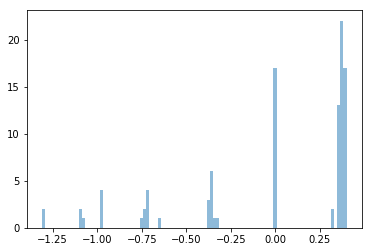

In [16]:
# Duration between diff behavior from PostTransition (min, max, avg)
gap_Ptrans = []
for sample in found_transitions:
    for found_transition in sample:
        gap_Ptrans.append((found_transition["second_event_start"])-(found_transition["first_event_end"]))
        
        # Test minus valus
        if ((found_transition["second_event_start"])-(found_transition["first_event_end"])) < -4:
            print(bt.sample_id, found_transition["first_event_end"], found_transition["second_event_start"]) 
#print(gap_Ptrans)

avg_duration = np.mean(gap_Ptrans)
max_duration = np.max(gap_Ptrans)
min_duration = np.min(gap_Ptrans)

print(avg_duration)
print(max_duration)
print(min_duration)

# Histogram
plt.hist(gap_Ptrans, bins=100, alpha=0.5)
plt.show()

In [17]:
# Use the predefined CellTransConfig to filter by celltype and pattern.
# The results are merged_ordered and interpolated.
cell_Ptrans_configs = []
all_Ptrans_events = []


for sample in tqdm(found_transitions):
    #sample_ls_trans = []
    for found_transition in sample:
        
        # For all behavior except stimulus
        #sample_ls_trans.append(found_transition["second_event_start"]) 
        cell_Ptrans_configs.append(CellTransConfig(found_transition["sample_id"], "A00c", 
                                                  found_transition["second_event_start"]))
        
        # For stimulus as first_event
        ##sample_ls_trans.append(found_transition["first_event_start"]) 
        #cell_Ptrans_configs.append(CellTransConfig(found_transition["sample_id"], "basin", 
        #                                          found_transition["first_event_start"], 'A4L'))

# Extract for specific time window and align several events. 
# Define timepoints pre and post an event (event_df). 
# This works for single sample or multiple samples aligned 
# Note: In cell_subset_df, time was set to index, because for the previous avg calculation 
# Add index and time = column

# Set the window range left and right from the event (in seconds)
left_half_window_size = 100.0 
right_half_window_size = 200.0

# trans_df defined in pargraph before 
windows = []
n_behavior = 0

for ctc in tqdm(cell_Ptrans_configs):
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
    # Extract columns matching our cell type and the optional filter pattern.
    # Pandas' filter() operations works on columns for DataFrames by default.
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    #print(cell_subset_df['time'])
    
    # Don't apply filter regex, but take all cells from lm_data
    #cell_subset_df =  lm_data.get(ctc.sample_id)#Get subset of cells 
    #cell_subset_df.reset_index(inplace = True, drop = True) # Add index and time = column
    #print(cell_subset_df)
    
    n_behavior += 1
    window_start = ctc.event_time - left_half_window_size
    window_end = ctc.event_time + right_half_window_size
        
    # Get subset of rows between window_start and window_end       
    trans = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]
    # Normalizing the data to align on beginning of selected
    # behavior (event_df = Zero) by substracting events in window
    # around start of event of interest from start of event interest.
    # Note: using ":" in event.loc[] will select "all rows" in our window.
    #trans.loc[:, 'time'] = trans['time'] - row['time']
    trans.loc[:, 'time'] = trans['time'] - ctc.event_time
    
    # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
    trans.rename(lambda x: '{}_{}_{}'.format(ctc.sample_id, x, n_behavior), axis = 'columns', inplace = True) 

    # Rename time collum to time
    trans.rename(columns={ trans.columns[0]: 'time' }, inplace = True) 
    all_Ptrans_events.append(trans) # Append a list with all event
      
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_Ptrans_df = all_Ptrans_events.pop(0)
for right_df in all_Ptrans_events:
    all_Ptrans_df = pd.merge_ordered(all_Ptrans_df, right_df, on="time", how="outer")

# Resets the index as time and drops time column
all_Ptrans_df.index = all_Ptrans_df["time"]
del all_Ptrans_df["time"]        
#print(all_Ptrans_df)

# Index intepolation (linear interpolatione not on all_df, because index [=time] is not eaqually distributed)
int_all_Ptrans_df = all_Ptrans_df.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')
#print(int_all_Ptrans_df)


  0%|          | 0/99 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
  1%|          | 1/99 [00:00<00:12,  7.84it/s]

0          0.000
1          0.332
2          0.661
3          0.991
4          1.319
5          1.649
6          1.978
7          2.307
8          2.636
9          2.966
10         3.295
11         3.624
12         3.953
13         4.282
14         4.611
15         4.942
16         5.270
17         5.599
18         5.928
19         6.258
20         6.587
21         6.916
22         7.245
23         7.574
24         7.904
25         8.233
26         8.563
27         8.891
28         9.220
29         9.549
          ...   
3168    1042.934
3169    1043.263
3170    1043.593
3171    1043.922
3172    1044.251
3173    1044.580
3174    1044.909
3175    1045.239
3176    1045.568
3177    1045.897
3178    1046.226
3179    1046.556
3180    1046.884
3181    1047.214
3182    1047.543
3183    1047.873
3184    1048.201
3185    1048.531
3186    1048.859
3187    1049.189
3188    1049.518
3189    1049.848
3190    1050.177
3191    1050.506
3192    1050.835
3193    1051.164
3194    1051.494
3195    1051.8

  3%|▎         | 3/99 [00:00<00:12,  7.81it/s]

0          0.000
1          0.362
2          0.721
3          1.080
4          1.439
5          1.798
6          2.157
7          2.516
8          2.875
9          3.234
10         3.593
11         3.952
12         4.311
13         4.669
14         5.030
15         5.388
16         5.747
17         6.106
18         6.465
19         6.824
20         7.183
21         7.542
22         7.901
23         8.260
24         8.619
25         8.978
26         9.337
27         9.696
28        10.055
29        10.414
          ...   
6655    2389.207
6656    2389.567
6657    2389.925
6658    2390.284
6659    2390.643
6660    2391.002
6661    2391.361
6662    2391.720
6663    2392.079
6664    2392.438
6665    2392.798
6666    2393.157
6667    2393.516
6668    2393.875
6669    2394.233
6670    2394.592
6671    2394.951
6672    2395.310
6673    2395.669
6674    2396.028
6675    2396.388
6676    2396.747
6677    2397.106
6678    2397.465
6679    2397.823
6680    2398.183
6681    2398.541
6682    2398.9

  5%|▌         | 5/99 [00:00<00:12,  7.77it/s]

0          0.000
1          0.362
2          0.721
3          1.080
4          1.439
5          1.798
6          2.157
7          2.516
8          2.875
9          3.234
10         3.593
11         3.952
12         4.311
13         4.669
14         5.030
15         5.388
16         5.747
17         6.106
18         6.465
19         6.824
20         7.183
21         7.542
22         7.901
23         8.260
24         8.619
25         8.978
26         9.337
27         9.696
28        10.055
29        10.414
          ...   
6655    2389.207
6656    2389.567
6657    2389.925
6658    2390.284
6659    2390.643
6660    2391.002
6661    2391.361
6662    2391.720
6663    2392.079
6664    2392.438
6665    2392.798
6666    2393.157
6667    2393.516
6668    2393.875
6669    2394.233
6670    2394.592
6671    2394.951
6672    2395.310
6673    2395.669
6674    2396.028
6675    2396.388
6676    2396.747
6677    2397.106
6678    2397.465
6679    2397.823
6680    2398.183
6681    2398.541
6682    2398.9

  7%|▋         | 7/99 [00:00<00:11,  7.90it/s]

0          0.000
1          0.359
2          0.716
3          1.073
4          1.429
5          1.786
6          2.143
7          2.499
8          2.855
9          3.213
10         3.569
11         3.926
12         4.282
13         4.639
14         4.995
15         5.352
16         5.709
17         6.065
18         6.422
19         6.778
20         7.136
21         7.491
22         7.848
23         8.205
24         8.562
25         8.918
26         9.275
27         9.631
28         9.988
29        10.344
          ...   
4896    1745.960
4897    1746.317
4898    1746.673
4899    1747.029
4900    1747.386
4901    1747.743
4902    1748.099
4903    1748.457
4904    1748.813
4905    1749.169
4906    1749.526
4907    1749.883
4908    1750.240
4909    1750.596
4910    1750.953
4911    1751.309
4912    1751.666
4913    1752.022
4914    1752.378
4915    1752.736
4916    1753.092
4917    1753.449
4918    1753.805
4919    1754.162
4920    1754.519
4921    1754.875
4922    1755.231
4923    1755.5

  9%|▉         | 9/99 [00:01<00:11,  7.90it/s]

0          0.000
1          0.359
2          0.716
3          1.073
4          1.429
5          1.786
6          2.143
7          2.499
8          2.855
9          3.213
10         3.569
11         3.926
12         4.282
13         4.639
14         4.995
15         5.352
16         5.709
17         6.065
18         6.422
19         6.778
20         7.136
21         7.491
22         7.848
23         8.205
24         8.562
25         8.918
26         9.275
27         9.631
28         9.988
29        10.344
          ...   
4896    1745.960
4897    1746.317
4898    1746.673
4899    1747.029
4900    1747.386
4901    1747.743
4902    1748.099
4903    1748.457
4904    1748.813
4905    1749.169
4906    1749.526
4907    1749.883
4908    1750.240
4909    1750.596
4910    1750.953
4911    1751.309
4912    1751.666
4913    1752.022
4914    1752.378
4915    1752.736
4916    1753.092
4917    1753.449
4918    1753.805
4919    1754.162
4920    1754.519
4921    1754.875
4922    1755.231
4923    1755.5

 11%|█         | 11/99 [00:01<00:11,  7.74it/s]

0          0.000
1          0.359
2          0.716
3          1.073
4          1.429
5          1.786
6          2.143
7          2.499
8          2.855
9          3.213
10         3.569
11         3.926
12         4.282
13         4.639
14         4.995
15         5.352
16         5.709
17         6.065
18         6.422
19         6.778
20         7.136
21         7.491
22         7.848
23         8.205
24         8.562
25         8.918
26         9.275
27         9.631
28         9.988
29        10.344
          ...   
4896    1745.960
4897    1746.317
4898    1746.673
4899    1747.029
4900    1747.386
4901    1747.743
4902    1748.099
4903    1748.457
4904    1748.813
4905    1749.169
4906    1749.526
4907    1749.883
4908    1750.240
4909    1750.596
4910    1750.953
4911    1751.309
4912    1751.666
4913    1752.022
4914    1752.378
4915    1752.736
4916    1753.092
4917    1753.449
4918    1753.805
4919    1754.162
4920    1754.519
4921    1754.875
4922    1755.231
4923    1755.5

 13%|█▎        | 13/99 [00:01<00:11,  7.81it/s]

0          0.000
1          0.331
2          0.657
3          0.984
4          1.311
5          1.639
6          1.966
7          2.293
8          2.620
9          2.948
10         3.275
11         3.602
12         3.929
13         4.256
14         4.583
15         4.911
16         5.238
17         5.565
18         5.892
19         6.220
20         6.546
21         6.874
22         7.201
23         7.528
24         7.856
25         8.183
26         8.510
27         8.837
28         9.164
29         9.492
          ...   
7306    2390.585
7307    2390.912
7308    2391.239
7309    2391.567
7310    2391.895
7311    2392.221
7312    2392.548
7313    2392.876
7314    2393.203
7315    2393.530
7316    2393.857
7317    2394.185
7318    2394.512
7319    2394.839
7320    2395.166
7321    2395.494
7322    2395.821
7323    2396.148
7324    2396.475
7325    2396.802
7326    2397.129
7327    2397.457
7328    2397.784
7329    2398.111
7330    2398.438
7331    2398.765
7332    2399.092
7333    2399.4

 15%|█▌        | 15/99 [00:01<00:10,  7.93it/s]

0          0.000
1          0.331
2          0.657
3          0.984
4          1.311
5          1.639
6          1.966
7          2.293
8          2.620
9          2.948
10         3.275
11         3.602
12         3.929
13         4.256
14         4.583
15         4.911
16         5.238
17         5.565
18         5.892
19         6.220
20         6.546
21         6.874
22         7.201
23         7.528
24         7.856
25         8.183
26         8.510
27         8.837
28         9.164
29         9.492
          ...   
7306    2390.585
7307    2390.912
7308    2391.239
7309    2391.567
7310    2391.895
7311    2392.221
7312    2392.548
7313    2392.876
7314    2393.203
7315    2393.530
7316    2393.857
7317    2394.185
7318    2394.512
7319    2394.839
7320    2395.166
7321    2395.494
7322    2395.821
7323    2396.148
7324    2396.475
7325    2396.802
7326    2397.129
7327    2397.457
7328    2397.784
7329    2398.111
7330    2398.438
7331    2398.765
7332    2399.092
7333    2399.4

 17%|█▋        | 17/99 [00:02<00:10,  7.93it/s]

0          0.000
1          0.331
2          0.657
3          0.984
4          1.311
5          1.639
6          1.966
7          2.293
8          2.620
9          2.948
10         3.275
11         3.602
12         3.929
13         4.256
14         4.583
15         4.911
16         5.238
17         5.565
18         5.892
19         6.220
20         6.546
21         6.874
22         7.201
23         7.528
24         7.856
25         8.183
26         8.510
27         8.837
28         9.164
29         9.492
          ...   
7306    2390.585
7307    2390.912
7308    2391.239
7309    2391.567
7310    2391.895
7311    2392.221
7312    2392.548
7313    2392.876
7314    2393.203
7315    2393.530
7316    2393.857
7317    2394.185
7318    2394.512
7319    2394.839
7320    2395.166
7321    2395.494
7322    2395.821
7323    2396.148
7324    2396.475
7325    2396.802
7326    2397.129
7327    2397.457
7328    2397.784
7329    2398.111
7330    2398.438
7331    2398.765
7332    2399.092
7333    2399.4

 19%|█▉        | 19/99 [00:02<00:10,  7.85it/s]

0          0.000
1          0.330
2          0.657
3          0.984
4          1.311
5          1.639
6          1.966
7          2.293
8          2.620
9          2.947
10         3.275
11         3.602
12         3.929
13         4.256
14         4.583
15         4.911
16         5.238
17         5.566
18         5.892
19         6.220
20         6.547
21         6.874
22         7.201
23         7.528
24         7.855
25         8.183
26         8.510
27         8.837
28         9.164
29         9.491
          ...   
7306    2390.585
7307    2390.912
7308    2391.240
7309    2391.568
7310    2391.894
7311    2392.221
7312    2392.548
7313    2392.876
7314    2393.203
7315    2393.530
7316    2393.858
7317    2394.185
7318    2394.512
7319    2394.839
7320    2395.166
7321    2395.493
7322    2395.820
7323    2396.148
7324    2396.475
7325    2396.802
7326    2397.129
7327    2397.457
7328    2397.784
7329    2398.111
7330    2398.438
7331    2398.766
7332    2399.092
7333    2399.4

 21%|██        | 21/99 [00:02<00:09,  7.88it/s]

0          0.000
1          0.323
2          0.644
3          0.964
4          1.285
5          1.605
6          1.926
7          2.246
8          2.567
9          2.887
10         3.208
11         3.528
12         3.848
13         4.169
14         4.490
15         4.810
16         5.130
17         5.451
18         5.771
19         6.092
20         6.413
21         6.733
22         7.054
23         7.374
24         7.694
25         8.014
26         8.336
27         8.656
28         8.976
29         9.297
          ...   
6672    2138.299
6673    2138.619
6674    2138.939
6675    2139.260
6676    2139.580
6677    2139.901
6678    2140.221
6679    2140.542
6680    2140.863
6681    2141.183
6682    2141.503
6683    2141.824
6684    2142.145
6685    2142.465
6686    2142.785
6687    2143.106
6688    2143.426
6689    2143.747
6690    2144.067
6691    2144.388
6692    2144.708
6693    2145.028
6694    2145.349
6695    2145.670
6696    2145.990
6697    2146.311
6698    2146.631
6699    2146.9

 23%|██▎       | 23/99 [00:02<00:09,  7.84it/s]

0          0.000
1          0.374
2          0.745
3          1.116
4          1.487
5          1.858
6          2.229
7          2.600
8          2.971
9          3.342
10         3.713
11         4.084
12         4.455
13         4.826
14         5.197
15         5.568
16         5.939
17         6.310
18         6.681
19         7.052
20         7.423
21         7.794
22         8.165
23         8.536
24         8.907
25         9.278
26         9.650
27        10.020
28        10.391
29        10.762
          ...   
6439    2388.932
6440    2389.302
6441    2389.674
6442    2390.044
6443    2390.416
6444    2390.787
6445    2391.158
6446    2391.528
6447    2391.900
6448    2392.271
6449    2392.642
6450    2393.013
6451    2393.384
6452    2393.755
6453    2394.125
6454    2394.496
6455    2394.868
6456    2395.239
6457    2395.610
6458    2395.981
6459    2396.352
6460    2396.723
6461    2397.094
6462    2397.465
6463    2397.836
6464    2398.207
6465    2398.578
6466    2398.9

 25%|██▌       | 25/99 [00:03<00:09,  7.77it/s]

0          0.000
1          0.374
2          0.745
3          1.116
4          1.487
5          1.858
6          2.229
7          2.600
8          2.971
9          3.342
10         3.713
11         4.084
12         4.455
13         4.826
14         5.197
15         5.568
16         5.939
17         6.310
18         6.681
19         7.052
20         7.423
21         7.794
22         8.165
23         8.536
24         8.907
25         9.278
26         9.650
27        10.020
28        10.391
29        10.762
          ...   
6439    2388.932
6440    2389.302
6441    2389.674
6442    2390.044
6443    2390.416
6444    2390.787
6445    2391.158
6446    2391.528
6447    2391.900
6448    2392.271
6449    2392.642
6450    2393.013
6451    2393.384
6452    2393.755
6453    2394.125
6454    2394.496
6455    2394.868
6456    2395.239
6457    2395.610
6458    2395.981
6459    2396.352
6460    2396.723
6461    2397.094
6462    2397.465
6463    2397.836
6464    2398.207
6465    2398.578
6466    2398.9

 27%|██▋       | 27/99 [00:03<00:09,  7.66it/s]

0          0.000
1          0.347
2          0.692
3          1.036
4          1.380
5          1.725
6          2.069
7          2.413
8          2.759
9          3.103
10         3.447
11         3.792
12         4.136
13         4.480
14         4.825
15         5.169
16         5.513
17         5.858
18         6.202
19         6.546
20         6.891
21         7.236
22         7.580
23         7.924
24         8.268
25         8.613
26         8.957
27         9.301
28         9.647
29         9.990
          ...   
6808    2344.736
6809    2345.081
6810    2345.425
6811    2345.770
6812    2346.114
6813    2346.458
6814    2346.803
6815    2347.147
6816    2347.492
6817    2347.836
6818    2348.181
6819    2348.525
6820    2348.870
6821    2349.214
6822    2349.558
6823    2349.903
6824    2350.247
6825    2350.591
6826    2350.935
6827    2351.281
6828    2351.625
6829    2351.969
6830    2352.313
6831    2352.657
6832    2353.002
6833    2353.346
6834    2353.691
6835    2354.0

 29%|██▉       | 29/99 [00:03<00:09,  7.19it/s]

0          0.000
1          0.359
2          0.715
3          1.070
4          1.426
5          1.782
6          2.137
7          2.493
8          2.849
9          3.205
10         3.561
11         3.917
12         4.273
13         4.629
14         4.984
15         5.340
16         5.696
17         6.052
18         6.407
19         6.763
20         7.119
21         7.475
22         7.831
23         8.186
24         8.543
25         8.898
26         9.254
27         9.610
28         9.965
29        10.321
          ...   
6722    2391.750
6723    2392.106
6724    2392.462
6725    2392.817
6726    2393.173
6727    2393.530
6728    2393.885
6729    2394.241
6730    2394.596
6731    2394.953
6732    2395.308
6733    2395.664
6734    2396.021
6735    2396.376
6736    2396.731
6737    2397.088
6738    2397.443
6739    2397.799
6740    2398.155
6741    2398.510
6742    2398.867
6743    2399.222
6744    2399.578
6745    2399.934
6746    2400.290
6747    2400.646
6748    2401.001
6749    2401.3

 31%|███▏      | 31/99 [00:04<00:10,  6.62it/s]

0          0.000
1          0.359
2          0.715
3          1.070
4          1.426
5          1.782
6          2.137
7          2.493
8          2.849
9          3.205
10         3.561
11         3.917
12         4.273
13         4.629
14         4.984
15         5.340
16         5.696
17         6.052
18         6.407
19         6.763
20         7.119
21         7.475
22         7.831
23         8.186
24         8.543
25         8.898
26         9.254
27         9.610
28         9.965
29        10.321
          ...   
6722    2391.750
6723    2392.106
6724    2392.462
6725    2392.817
6726    2393.173
6727    2393.530
6728    2393.885
6729    2394.241
6730    2394.596
6731    2394.953
6732    2395.308
6733    2395.664
6734    2396.021
6735    2396.376
6736    2396.731
6737    2397.088
6738    2397.443
6739    2397.799
6740    2398.155
6741    2398.510
6742    2398.867
6743    2399.222
6744    2399.578
6745    2399.934
6746    2400.290
6747    2400.646
6748    2401.001
6749    2401.3

 33%|███▎      | 33/99 [00:04<00:10,  6.54it/s]

0          0.000
1          0.369
2          0.737
3          1.104
4          1.470
5          1.837
6          2.204
7          2.570
8          2.937
9          3.304
10         3.671
11         4.038
12         4.405
13         4.771
14         5.138
15         5.505
16         5.872
17         6.239
18         6.606
19         6.973
20         7.339
21         7.706
22         8.073
23         8.440
24         8.806
25         9.173
26         9.541
27         9.907
28        10.274
29        10.641
          ...   
6519    2391.232
6520    2391.599
6521    2391.965
6522    2392.332
6523    2392.699
6524    2393.066
6525    2393.433
6526    2393.800
6527    2394.166
6528    2394.533
6529    2394.899
6530    2395.266
6531    2395.633
6532    2396.000
6533    2396.367
6534    2396.734
6535    2397.101
6536    2397.467
6537    2397.834
6538    2398.201
6539    2398.568
6540    2398.934
6541    2399.302
6542    2399.668
6543    2400.035
6544    2400.402
6545    2400.769
6546    2401.1

 35%|███▌      | 35/99 [00:04<00:10,  6.24it/s]

0          0.000
1          0.369
2          0.737
3          1.104
4          1.470
5          1.837
6          2.204
7          2.570
8          2.937
9          3.304
10         3.671
11         4.038
12         4.405
13         4.771
14         5.138
15         5.505
16         5.872
17         6.239
18         6.606
19         6.973
20         7.339
21         7.706
22         8.073
23         8.440
24         8.806
25         9.173
26         9.541
27         9.907
28        10.274
29        10.641
          ...   
6519    2391.232
6520    2391.599
6521    2391.965
6522    2392.332
6523    2392.699
6524    2393.066
6525    2393.433
6526    2393.800
6527    2394.166
6528    2394.533
6529    2394.899
6530    2395.266
6531    2395.633
6532    2396.000
6533    2396.367
6534    2396.734
6535    2397.101
6536    2397.467
6537    2397.834
6538    2398.201
6539    2398.568
6540    2398.934
6541    2399.302
6542    2399.668
6543    2400.035
6544    2400.402
6545    2400.769
6546    2401.1

 37%|███▋      | 37/99 [00:05<00:10,  6.06it/s]

0          0.000
1          0.369
2          0.737
3          1.104
4          1.470
5          1.837
6          2.204
7          2.570
8          2.937
9          3.304
10         3.671
11         4.038
12         4.405
13         4.771
14         5.138
15         5.505
16         5.872
17         6.239
18         6.606
19         6.973
20         7.339
21         7.706
22         8.073
23         8.440
24         8.806
25         9.173
26         9.541
27         9.907
28        10.274
29        10.641
          ...   
6519    2391.232
6520    2391.599
6521    2391.965
6522    2392.332
6523    2392.699
6524    2393.066
6525    2393.433
6526    2393.800
6527    2394.166
6528    2394.533
6529    2394.899
6530    2395.266
6531    2395.633
6532    2396.000
6533    2396.367
6534    2396.734
6535    2397.101
6536    2397.467
6537    2397.834
6538    2398.201
6539    2398.568
6540    2398.934
6541    2399.302
6542    2399.668
6543    2400.035
6544    2400.402
6545    2400.769
6546    2401.1

 39%|███▉      | 39/99 [00:05<00:09,  6.07it/s]

0          0.000
1          0.377
2          0.751
3          1.125
4          1.499
5          1.873
6          2.247
7          2.621
8          2.995
9          3.369
10         3.743
11         4.117
12         4.491
13         4.865
14         5.239
15         5.613
16         5.987
17         6.361
18         6.735
19         7.109
20         7.483
21         7.857
22         8.232
23         8.605
24         8.979
25         9.353
26         9.727
27        10.101
28        10.476
29        10.850
          ...   
6393    2391.045
6394    2391.419
6395    2391.793
6396    2392.167
6397    2392.541
6398    2392.915
6399    2393.288
6400    2393.663
6401    2394.036
6402    2394.411
6403    2394.785
6404    2395.159
6405    2395.533
6406    2395.906
6407    2396.281
6408    2396.655
6409    2397.029
6410    2397.403
6411    2397.777
6412    2398.151
6413    2398.525
6414    2398.899
6415    2399.273
6416    2399.647
6417    2400.021
6418    2400.395
6419    2400.769
6420    2401.1

 41%|████▏     | 41/99 [00:05<00:09,  6.06it/s]

0          0.000
1          0.377
2          0.751
3          1.125
4          1.499
5          1.873
6          2.247
7          2.621
8          2.995
9          3.369
10         3.743
11         4.117
12         4.491
13         4.865
14         5.239
15         5.613
16         5.987
17         6.361
18         6.735
19         7.109
20         7.483
21         7.857
22         8.232
23         8.605
24         8.979
25         9.353
26         9.727
27        10.101
28        10.476
29        10.850
          ...   
6393    2391.045
6394    2391.419
6395    2391.793
6396    2392.167
6397    2392.541
6398    2392.915
6399    2393.288
6400    2393.663
6401    2394.036
6402    2394.411
6403    2394.785
6404    2395.159
6405    2395.533
6406    2395.906
6407    2396.281
6408    2396.655
6409    2397.029
6410    2397.403
6411    2397.777
6412    2398.151
6413    2398.525
6414    2398.899
6415    2399.273
6416    2399.647
6417    2400.021
6418    2400.395
6419    2400.769
6420    2401.1

 43%|████▎     | 43/99 [00:06<00:08,  6.37it/s]

0         0.000000
1         0.375000
2         0.747000
3         1.119000
4         1.491000
5         1.863000
6         2.235000
7         2.606000
8         2.979000
9         3.351000
10        3.723000
11        4.095000
12        4.467000
13        4.839000
14        5.212000
15        5.583000
16        5.955000
17        6.327000
18        6.699000
19        7.071000
20        7.443000
21        7.815000
22        8.188000
23        8.559000
24        8.931000
25        9.303000
26        9.675000
27       10.047000
28       10.419000
29       10.791000
           ...    
2627    977.271511
2628    977.643520
2629    978.015530
2630    978.387539
2631    978.759548
2632    979.131558
2633    979.503567
2634    979.875576
2635    980.247586
2636    980.619595
2637    980.991604
2638    981.363614
2639    981.735623
2640    982.107633
2641    982.479642
2642    982.851651
2643    983.223661
2644    983.595670
2645    983.967679
2646    984.339689
2647    984.711698
2648    985.

 45%|████▌     | 45/99 [00:06<00:07,  6.99it/s]

0         0.000000
1         0.375000
2         0.747000
3         1.119000
4         1.491000
5         1.863000
6         2.235000
7         2.606000
8         2.979000
9         3.351000
10        3.723000
11        4.095000
12        4.467000
13        4.839000
14        5.212000
15        5.583000
16        5.955000
17        6.327000
18        6.699000
19        7.071000
20        7.443000
21        7.815000
22        8.188000
23        8.559000
24        8.931000
25        9.303000
26        9.675000
27       10.047000
28       10.419000
29       10.791000
           ...    
2627    977.271511
2628    977.643520
2629    978.015530
2630    978.387539
2631    978.759548
2632    979.131558
2633    979.503567
2634    979.875576
2635    980.247586
2636    980.619595
2637    980.991604
2638    981.363614
2639    981.735623
2640    982.107633
2641    982.479642
2642    982.851651
2643    983.223661
2644    983.595670
2645    983.967679
2646    984.339689
2647    984.711698
2648    985.

 47%|████▋     | 47/99 [00:06<00:07,  7.23it/s]

0          0.000
1          0.373
2          0.742
3          1.113
4          1.483
5          1.853
6          2.223
7          2.593
8          2.963
9          3.333
10         3.703
11         4.073
12         4.443
13         4.813
14         5.183
15         5.553
16         5.923
17         6.293
18         6.663
19         7.033
20         7.403
21         7.773
22         8.143
23         8.514
24         8.883
25         9.253
26         9.623
27         9.993
28        10.363
29        10.733
          ...   
6463    2391.373
6464    2391.743
6465    2392.113
6466    2392.483
6467    2392.853
6468    2393.223
6469    2393.593
6470    2393.963
6471    2394.333
6472    2394.703
6473    2395.073
6474    2395.443
6475    2395.813
6476    2396.183
6477    2396.553
6478    2396.924
6479    2397.293
6480    2397.663
6481    2398.033
6482    2398.403
6483    2398.773
6484    2399.143
6485    2399.513
6486    2399.883
6487    2400.253
6488    2400.624
6489    2400.993
6490    2401.3

 49%|████▉     | 49/99 [00:06<00:06,  7.27it/s]

0          0.000
1          0.382
2          0.760
3          1.139
4          1.517
5          1.895
6          2.274
7          2.653
8          3.031
9          3.410
10         3.788
11         4.167
12         4.545
13         4.924
14         5.302
15         5.680
16         6.059
17         6.437
18         6.815
19         7.195
20         7.573
21         7.952
22         8.330
23         8.709
24         9.087
25         9.466
26         9.844
27        10.223
28        10.601
29        10.979
          ...   
4829    1827.729
4830    1828.108
4831    1828.486
4832    1828.864
4833    1829.243
4834    1829.622
4835    1830.000
4836    1830.378
4837    1830.756
4838    1831.136
4839    1831.514
4840    1831.892
4841    1832.271
4842    1832.649
4843    1833.028
4844    1833.406
4845    1833.785
4846    1834.163
4847    1834.542
4848    1834.920
4849    1835.298
4850    1835.677
4851    1836.056
4852    1836.434
4853    1836.812
4854    1837.192
4855    1837.569
4856    1837.9

 52%|█████▏    | 51/99 [00:07<00:06,  7.51it/s]

0          0.000
1          0.363
2          0.723
3          1.083
4          1.443
5          1.803
6          2.163
7          2.523
8          2.883
9          3.243
10         3.603
11         3.963
12         4.323
13         4.683
14         5.043
15         5.403
16         5.763
17         6.123
18         6.483
19         6.843
20         7.203
21         7.563
22         7.923
23         8.283
24         8.643
25         9.003
26         9.363
27         9.723
28        10.083
29        10.443
          ...   
6637    2389.383
6638    2389.743
6639    2390.103
6640    2390.463
6641    2390.823
6642    2391.183
6643    2391.542
6644    2391.903
6645    2392.263
6646    2392.623
6647    2392.983
6648    2393.344
6649    2393.703
6650    2394.063
6651    2394.423
6652    2394.783
6653    2395.143
6654    2395.503
6655    2395.864
6656    2396.224
6657    2396.583
6658    2396.943
6659    2397.303
6660    2397.664
6661    2398.023
6662    2398.383
6663    2398.743
6664    2399.1

 54%|█████▎    | 53/99 [00:07<00:06,  7.44it/s]

0          0.000
1          0.363
2          0.723
3          1.083
4          1.443
5          1.803
6          2.163
7          2.523
8          2.883
9          3.243
10         3.603
11         3.963
12         4.323
13         4.683
14         5.043
15         5.403
16         5.763
17         6.123
18         6.483
19         6.843
20         7.203
21         7.563
22         7.923
23         8.283
24         8.643
25         9.003
26         9.363
27         9.723
28        10.083
29        10.443
          ...   
6637    2389.383
6638    2389.743
6639    2390.103
6640    2390.463
6641    2390.823
6642    2391.183
6643    2391.542
6644    2391.903
6645    2392.263
6646    2392.623
6647    2392.983
6648    2393.344
6649    2393.703
6650    2394.063
6651    2394.423
6652    2394.783
6653    2395.143
6654    2395.503
6655    2395.864
6656    2396.224
6657    2396.583
6658    2396.943
6659    2397.303
6660    2397.664
6661    2398.023
6662    2398.383
6663    2398.743
6664    2399.1

 56%|█████▌    | 55/99 [00:07<00:05,  7.47it/s]

0          0.000
1          0.363
2          0.723
3          1.083
4          1.443
5          1.803
6          2.163
7          2.523
8          2.883
9          3.243
10         3.603
11         3.963
12         4.323
13         4.683
14         5.043
15         5.403
16         5.763
17         6.123
18         6.483
19         6.843
20         7.203
21         7.563
22         7.923
23         8.283
24         8.643
25         9.003
26         9.363
27         9.723
28        10.083
29        10.443
          ...   
6637    2389.383
6638    2389.743
6639    2390.103
6640    2390.463
6641    2390.823
6642    2391.183
6643    2391.542
6644    2391.903
6645    2392.263
6646    2392.623
6647    2392.983
6648    2393.344
6649    2393.703
6650    2394.063
6651    2394.423
6652    2394.783
6653    2395.143
6654    2395.503
6655    2395.864
6656    2396.224
6657    2396.583
6658    2396.943
6659    2397.303
6660    2397.664
6661    2398.023
6662    2398.383
6663    2398.743
6664    2399.1

 58%|█████▊    | 57/99 [00:07<00:05,  7.50it/s]

0          0.000
1          0.363
2          0.723
3          1.083
4          1.443
5          1.803
6          2.163
7          2.523
8          2.883
9          3.243
10         3.603
11         3.963
12         4.323
13         4.683
14         5.043
15         5.403
16         5.763
17         6.123
18         6.483
19         6.843
20         7.203
21         7.563
22         7.923
23         8.283
24         8.643
25         9.003
26         9.363
27         9.723
28        10.083
29        10.443
          ...   
6637    2389.383
6638    2389.743
6639    2390.103
6640    2390.463
6641    2390.823
6642    2391.183
6643    2391.542
6644    2391.903
6645    2392.263
6646    2392.623
6647    2392.983
6648    2393.344
6649    2393.703
6650    2394.063
6651    2394.423
6652    2394.783
6653    2395.143
6654    2395.503
6655    2395.864
6656    2396.224
6657    2396.583
6658    2396.943
6659    2397.303
6660    2397.664
6661    2398.023
6662    2398.383
6663    2398.743
6664    2399.1

 60%|█████▉    | 59/99 [00:08<00:05,  7.51it/s]

0          0.000
1          0.374
2          0.745
3          1.117
4          1.488
5          1.859
6          2.230
7          2.601
8          2.972
9          3.343
10         3.714
11         4.085
12         4.456
13         4.827
14         5.198
15         5.570
16         5.940
17         6.311
18         6.682
19         7.054
20         7.425
21         7.796
22         8.167
23         8.538
24         8.910
25         9.280
26         9.651
27        10.022
28        10.394
29        10.764
          ...   
6343    2353.823
6344    2354.194
6345    2354.565
6346    2354.936
6347    2355.307
6348    2355.679
6349    2356.049
6350    2356.420
6351    2356.792
6352    2357.163
6353    2357.534
6354    2357.905
6355    2358.276
6356    2358.647
6357    2359.018
6358    2359.389
6359    2359.760
6360    2360.132
6361    2360.502
6362    2360.873
6363    2361.244
6364    2361.616
6365    2361.987
6366    2362.357
6367    2362.729
6368    2363.100
6369    2363.471
6370    2363.8

 62%|██████▏   | 61/99 [00:08<00:05,  7.53it/s]

0          0.000
1          0.374
2          0.745
3          1.117
4          1.488
5          1.859
6          2.230
7          2.601
8          2.972
9          3.343
10         3.714
11         4.085
12         4.456
13         4.827
14         5.198
15         5.570
16         5.940
17         6.311
18         6.682
19         7.054
20         7.425
21         7.796
22         8.167
23         8.538
24         8.910
25         9.280
26         9.651
27        10.022
28        10.394
29        10.764
          ...   
6343    2353.823
6344    2354.194
6345    2354.565
6346    2354.936
6347    2355.307
6348    2355.679
6349    2356.049
6350    2356.420
6351    2356.792
6352    2357.163
6353    2357.534
6354    2357.905
6355    2358.276
6356    2358.647
6357    2359.018
6358    2359.389
6359    2359.760
6360    2360.132
6361    2360.502
6362    2360.873
6363    2361.244
6364    2361.616
6365    2361.987
6366    2362.357
6367    2362.729
6368    2363.100
6369    2363.471
6370    2363.8

 64%|██████▎   | 63/99 [00:08<00:04,  7.57it/s]

0          0.000000
1          0.374000
2          0.745000
3          1.116000
4          1.487000
5          1.859000
6          2.229000
7          2.600000
8          2.972000
9          3.343000
10         3.714000
11         4.085000
12         4.456000
13         4.827000
14         5.198000
15         5.569000
16         5.941000
17         6.311000
18         6.682000
19         7.054000
20         7.425000
21         7.796000
22         8.167000
23         8.538000
24         8.909000
25         9.280000
26         9.652000
27        10.022000
28        10.394000
29        10.764000
           ...     
6444    2391.301859
6445    2391.672949
6446    2392.044038
6447    2392.415127
6448    2392.786216
6449    2393.157305
6450    2393.528395
6451    2393.899484
6452    2394.270573
6453    2394.641662
6454    2395.012751
6455    2395.383841
6456    2395.754930
6457    2396.126019
6458    2396.497108
6459    2396.868197
6460    2397.239286
6461    2397.610376
6462    2397.981465


 66%|██████▌   | 65/99 [00:08<00:04,  7.53it/s]

0          0.000000
1          0.374000
2          0.745000
3          1.116000
4          1.487000
5          1.859000
6          2.229000
7          2.600000
8          2.972000
9          3.343000
10         3.714000
11         4.085000
12         4.456000
13         4.827000
14         5.198000
15         5.569000
16         5.941000
17         6.311000
18         6.682000
19         7.054000
20         7.425000
21         7.796000
22         8.167000
23         8.538000
24         8.909000
25         9.280000
26         9.652000
27        10.022000
28        10.394000
29        10.764000
           ...     
6444    2391.301859
6445    2391.672949
6446    2392.044038
6447    2392.415127
6448    2392.786216
6449    2393.157305
6450    2393.528395
6451    2393.899484
6452    2394.270573
6453    2394.641662
6454    2395.012751
6455    2395.383841
6456    2395.754930
6457    2396.126019
6458    2396.497108
6459    2396.868197
6460    2397.239286
6461    2397.610376
6462    2397.981465


 68%|██████▊   | 67/99 [00:09<00:04,  7.55it/s]

0          0.000000
1          0.374000
2          0.745000
3          1.116000
4          1.487000
5          1.859000
6          2.229000
7          2.600000
8          2.972000
9          3.343000
10         3.714000
11         4.085000
12         4.456000
13         4.827000
14         5.198000
15         5.569000
16         5.941000
17         6.311000
18         6.682000
19         7.054000
20         7.425000
21         7.796000
22         8.167000
23         8.538000
24         8.909000
25         9.280000
26         9.652000
27        10.022000
28        10.394000
29        10.764000
           ...     
6444    2391.301859
6445    2391.672949
6446    2392.044038
6447    2392.415127
6448    2392.786216
6449    2393.157305
6450    2393.528395
6451    2393.899484
6452    2394.270573
6453    2394.641662
6454    2395.012751
6455    2395.383841
6456    2395.754930
6457    2396.126019
6458    2396.497108
6459    2396.868197
6460    2397.239286
6461    2397.610376
6462    2397.981465


 70%|██████▉   | 69/99 [00:09<00:03,  7.61it/s]

0          0.000
1          0.379
2          0.755
3          1.130
4          1.505
5          1.881
6          2.256
7          2.633
8          3.008
9          3.384
10         3.759
11         4.135
12         4.510
13         4.886
14         5.262
15         5.637
16         6.013
17         6.389
18         6.764
19         7.140
20         7.515
21         7.891
22         8.266
23         8.642
24         9.018
25         9.393
26         9.769
27        10.145
28        10.520
29        10.896
          ...   
6686    2511.327
6687    2511.703
6688    2512.079
6689    2512.454
6690    2512.830
6691    2513.206
6692    2513.581
6693    2513.957
6694    2514.332
6695    2514.708
6696    2515.083
6697    2515.459
6698    2515.835
6699    2516.210
6700    2516.586
6701    2516.962
6702    2517.337
6703    2517.713
6704    2518.088
6705    2518.464
6706    2518.840
6707    2519.215
6708    2519.591
6709    2519.966
6710    2520.342
6711    2520.717
6712    2521.093
6713    2521.4

 72%|███████▏  | 71/99 [00:09<00:03,  7.57it/s]

0          0.000
1          0.390
2          0.777
3          1.164
4          1.551
5          1.938
6          2.325
7          2.713
8          3.099
9          3.486
10         3.873
11         4.260
12         4.647
13         5.034
14         5.421
15         5.808
16         6.195
17         6.583
18         6.969
19         7.356
20         7.743
21         8.130
22         8.518
23         8.905
24         9.291
25         9.679
26        10.066
27        10.453
28        10.840
29        11.226
          ...   
6488    2510.922
6489    2511.309
6490    2511.696
6491    2512.083
6492    2512.470
6493    2512.857
6494    2513.244
6495    2513.631
6496    2514.018
6497    2514.405
6498    2514.792
6499    2515.179
6500    2515.566
6501    2515.953
6502    2516.340
6503    2516.727
6504    2517.114
6505    2517.501
6506    2517.888
6507    2518.275
6508    2518.662
6509    2519.049
6510    2519.436
6511    2519.823
6512    2520.210
6513    2520.598
6514    2520.984
6515    2521.3

 74%|███████▎  | 73/99 [00:09<00:03,  7.38it/s]

0          0.000
1          0.391
2          0.777
3          1.164
4          1.552
5          1.939
6          2.326
7          2.712
8          3.099
9          3.486
10         3.873
11         4.260
12         4.648
13         5.034
14         5.422
15         5.808
16         6.195
17         6.582
18         6.969
19         7.357
20         7.743
21         8.130
22         8.517
23         8.904
24         9.291
25         9.678
26        10.066
27        10.453
28        10.839
29        11.226
          ...   
6488    2510.922
6489    2511.309
6490    2511.695
6491    2512.083
6492    2512.469
6493    2512.857
6494    2513.244
6495    2513.631
6496    2514.018
6497    2514.405
6498    2514.792
6499    2515.179
6500    2515.566
6501    2515.952
6502    2516.340
6503    2516.727
6504    2517.114
6505    2517.500
6506    2517.888
6507    2518.275
6508    2518.662
6509    2519.049
6510    2519.437
6511    2519.823
6512    2520.210
6513    2520.597
6514    2520.984
6515    2521.3

 76%|███████▌  | 75/99 [00:10<00:03,  7.42it/s]

0          0.000
1          0.391
2          0.777
3          1.164
4          1.552
5          1.939
6          2.326
7          2.712
8          3.099
9          3.486
10         3.873
11         4.260
12         4.648
13         5.034
14         5.422
15         5.808
16         6.195
17         6.582
18         6.969
19         7.357
20         7.743
21         8.130
22         8.517
23         8.904
24         9.291
25         9.678
26        10.066
27        10.453
28        10.839
29        11.226
          ...   
6488    2510.922
6489    2511.309
6490    2511.695
6491    2512.083
6492    2512.469
6493    2512.857
6494    2513.244
6495    2513.631
6496    2514.018
6497    2514.405
6498    2514.792
6499    2515.179
6500    2515.566
6501    2515.952
6502    2516.340
6503    2516.727
6504    2517.114
6505    2517.500
6506    2517.888
6507    2518.275
6508    2518.662
6509    2519.049
6510    2519.437
6511    2519.823
6512    2520.210
6513    2520.597
6514    2520.984
6515    2521.3

 78%|███████▊  | 77/99 [00:10<00:02,  7.43it/s]

0          0.000
1          0.390
2          0.777
3          1.164
4          1.551
5          1.938
6          2.325
7          2.713
8          3.099
9          3.486
10         3.873
11         4.260
12         4.647
13         5.034
14         5.421
15         5.808
16         6.195
17         6.582
18         6.969
19         7.356
20         7.743
21         8.130
22         8.517
23         8.905
24         9.292
25         9.678
26        10.065
27        10.452
28        10.839
29        11.227
          ...   
6178    2390.948
6179    2391.336
6180    2391.723
6181    2392.110
6182    2392.497
6183    2392.885
6184    2393.271
6185    2393.658
6186    2394.045
6187    2394.432
6188    2394.819
6189    2395.206
6190    2395.594
6191    2395.980
6192    2396.367
6193    2396.754
6194    2397.141
6195    2397.528
6196    2397.915
6197    2398.302
6198    2398.689
6199    2399.076
6200    2399.463
6201    2399.850
6202    2400.237
6203    2400.624
6204    2401.011
6205    2401.3

 80%|███████▉  | 79/99 [00:10<00:02,  7.56it/s]

0          0.000
1          0.387
2          0.769
3          1.153
4          1.536
5          1.919
6          2.302
7          2.685
8          3.069
9          3.452
10         3.835
11         4.219
12         4.601
13         4.985
14         5.368
15         5.751
16         6.134
17         6.518
18         6.901
19         7.284
20         7.668
21         8.051
22         8.433
23         8.817
24         9.201
25         9.583
26         9.967
27        10.349
28        10.733
29        11.116
          ...   
6239    2390.848
6240    2391.231
6241    2391.614
6242    2391.997
6243    2392.381
6244    2392.764
6245    2393.147
6246    2393.530
6247    2393.914
6248    2394.297
6249    2394.679
6250    2395.063
6251    2395.446
6252    2395.830
6253    2396.212
6254    2396.596
6255    2396.979
6256    2397.362
6257    2397.745
6258    2398.129
6259    2398.512
6260    2398.895
6261    2399.279
6262    2399.662
6263    2400.045
6264    2400.428
6265    2400.811
6266    2401.1

 82%|████████▏ | 81/99 [00:11<00:02,  7.53it/s]

0          0.000
1          0.403
2          0.803
3          1.204
4          1.603
5          2.003
6          2.403
7          2.803
8          3.203
9          3.603
10         4.003
11         4.403
12         4.803
13         5.203
14         5.603
15         6.003
16         6.403
17         6.804
18         7.204
19         7.603
20         8.004
21         8.404
22         8.803
23         9.203
24         9.604
25        10.003
26        10.404
27        10.803
28        11.203
29        11.604
          ...   
6276    2510.466
6277    2510.866
6278    2511.266
6279    2511.667
6280    2512.066
6281    2512.466
6282    2512.866
6283    2513.266
6284    2513.666
6285    2514.066
6286    2514.467
6287    2514.866
6288    2515.267
6289    2515.666
6290    2516.066
6291    2516.467
6292    2516.866
6293    2517.266
6294    2517.667
6295    2518.066
6296    2518.467
6297    2518.866
6298    2519.267
6299    2519.667
6300    2520.067
6301    2520.467
6302    2520.867
6303    2521.2

 84%|████████▍ | 83/99 [00:11<00:02,  7.57it/s]

0          0.000
1          0.403
2          0.803
3          1.204
4          1.603
5          2.003
6          2.403
7          2.803
8          3.203
9          3.603
10         4.003
11         4.403
12         4.803
13         5.203
14         5.603
15         6.003
16         6.403
17         6.804
18         7.204
19         7.603
20         8.004
21         8.404
22         8.803
23         9.203
24         9.604
25        10.003
26        10.404
27        10.803
28        11.203
29        11.604
          ...   
6276    2510.466
6277    2510.866
6278    2511.266
6279    2511.667
6280    2512.066
6281    2512.466
6282    2512.866
6283    2513.266
6284    2513.666
6285    2514.066
6286    2514.467
6287    2514.866
6288    2515.267
6289    2515.666
6290    2516.066
6291    2516.467
6292    2516.866
6293    2517.266
6294    2517.667
6295    2518.066
6296    2518.467
6297    2518.866
6298    2519.267
6299    2519.667
6300    2520.067
6301    2520.467
6302    2520.867
6303    2521.2

 86%|████████▌ | 85/99 [00:11<00:01,  7.59it/s]

0          0.000
1          0.395
2          0.787
3          1.178
4          1.570
5          1.962
6          2.353
7          2.744
8          3.136
9          3.528
10         3.919
11         4.311
12         4.702
13         5.094
14         5.485
15         5.877
16         6.268
17         6.661
18         7.052
19         7.444
20         7.835
21         8.227
22         8.618
23         9.010
24         9.402
25         9.793
26        10.185
27        10.577
28        10.968
29        11.360
          ...   
6406    2508.654
6407    2509.046
6408    2509.437
6409    2509.829
6410    2510.221
6411    2510.613
6412    2511.004
6413    2511.396
6414    2511.787
6415    2512.179
6416    2512.570
6417    2512.962
6418    2513.354
6419    2513.745
6420    2514.137
6421    2514.529
6422    2514.920
6423    2515.312
6424    2515.703
6425    2516.095
6426    2516.487
6427    2516.878
6428    2517.270
6429    2517.662
6430    2518.053
6431    2518.444
6432    2518.836
6433    2519.2

 88%|████████▊ | 87/99 [00:11<00:01,  7.60it/s]

0          0.000
1          0.387
2          0.771
3          1.154
4          1.539
5          1.922
6          2.306
7          2.690
8          3.074
9          3.457
10         3.841
11         4.225
12         4.609
13         4.993
14         5.376
15         5.761
16         6.144
17         6.528
18         6.912
19         7.295
20         7.680
21         8.063
22         8.447
23         8.831
24         9.214
25         9.598
26         9.983
27        10.366
28        10.750
29        11.134
          ...   
6542    2510.884
6543    2511.268
6544    2511.652
6545    2512.036
6546    2512.420
6547    2512.803
6548    2513.187
6549    2513.571
6550    2513.954
6551    2514.338
6552    2514.722
6553    2515.106
6554    2515.490
6555    2515.874
6556    2516.258
6557    2516.642
6558    2517.025
6559    2517.409
6560    2517.793
6561    2518.177
6562    2518.560
6563    2518.944
6564    2519.328
6565    2519.712
6566    2520.096
6567    2520.479
6568    2520.863
6569    2521.2

 90%|████████▉ | 89/99 [00:12<00:01,  7.60it/s]

0          0.000
1          0.383
2          0.762
3          1.143
4          1.523
5          1.903
6          2.282
7          2.662
8          3.042
9          3.422
10         3.802
11         4.182
12         4.562
13         4.941
14         5.322
15         5.701
16         6.082
17         6.461
18         6.841
19         7.221
20         7.601
21         7.981
22         8.361
23         8.740
24         9.120
25         9.500
26         9.880
27        10.260
28        10.640
29        11.020
          ...   
6366    2418.379
6367    2418.760
6368    2419.139
6369    2419.519
6370    2419.899
6371    2420.279
6372    2420.659
6373    2421.038
6374    2421.419
6375    2421.799
6376    2422.178
6377    2422.558
6378    2422.938
6379    2423.318
6380    2423.698
6381    2424.078
6382    2424.458
6383    2424.838
6384    2425.218
6385    2425.597
6386    2425.978
6387    2426.358
6388    2426.737
6389    2427.117
6390    2427.496
6391    2427.877
6392    2428.257
6393    2428.6

 92%|█████████▏| 91/99 [00:12<00:01,  7.40it/s]

0          0.000
1          0.383
2          0.762
3          1.143
4          1.523
5          1.903
6          2.282
7          2.662
8          3.042
9          3.422
10         3.802
11         4.182
12         4.562
13         4.941
14         5.322
15         5.701
16         6.082
17         6.461
18         6.841
19         7.221
20         7.601
21         7.981
22         8.361
23         8.740
24         9.120
25         9.500
26         9.880
27        10.260
28        10.640
29        11.020
          ...   
6366    2418.379
6367    2418.760
6368    2419.139
6369    2419.519
6370    2419.899
6371    2420.279
6372    2420.659
6373    2421.038
6374    2421.419
6375    2421.799
6376    2422.178
6377    2422.558
6378    2422.938
6379    2423.318
6380    2423.698
6381    2424.078
6382    2424.458
6383    2424.838
6384    2425.218
6385    2425.597
6386    2425.978
6387    2426.358
6388    2426.737
6389    2427.117
6390    2427.496
6391    2427.877
6392    2428.257
6393    2428.6

 94%|█████████▍| 93/99 [00:12<00:00,  7.52it/s]

0          0.000
1          0.379
2          0.754
3          1.130
4          1.505
5          1.881
6          2.257
7          2.633
8          3.008
9          3.383
10         3.760
11         4.134
12         4.510
13         4.886
14         5.262
15         5.637
16         6.013
17         6.388
18         6.765
19         7.140
20         7.516
21         7.891
22         8.266
23         8.642
24         9.018
25         9.394
26         9.769
27        10.145
28        10.520
29        10.895
          ...   
6187    2323.898
6188    2324.274
6189    2324.649
6190    2325.025
6191    2325.400
6192    2325.777
6193    2326.151
6194    2326.528
6195    2326.903
6196    2327.278
6197    2327.655
6198    2328.030
6199    2328.405
6200    2328.781
6201    2329.156
6202    2329.532
6203    2329.908
6204    2330.284
6205    2330.659
6206    2331.035
6207    2331.410
6208    2331.786
6209    2332.162
6210    2332.537
6211    2332.913
6212    2333.288
6213    2333.664
6214    2334.0

 96%|█████████▌| 95/99 [00:12<00:00,  7.39it/s]

0          0.000
1          0.379
2          0.754
3          1.130
4          1.505
5          1.881
6          2.257
7          2.633
8          3.008
9          3.383
10         3.760
11         4.134
12         4.510
13         4.886
14         5.262
15         5.637
16         6.013
17         6.388
18         6.765
19         7.140
20         7.516
21         7.891
22         8.266
23         8.642
24         9.018
25         9.394
26         9.769
27        10.145
28        10.520
29        10.895
          ...   
6187    2323.898
6188    2324.274
6189    2324.649
6190    2325.025
6191    2325.400
6192    2325.777
6193    2326.151
6194    2326.528
6195    2326.903
6196    2327.278
6197    2327.655
6198    2328.030
6199    2328.405
6200    2328.781
6201    2329.156
6202    2329.532
6203    2329.908
6204    2330.284
6205    2330.659
6206    2331.035
6207    2331.410
6208    2331.786
6209    2332.162
6210    2332.537
6211    2332.913
6212    2333.288
6213    2333.664
6214    2334.0

 98%|█████████▊| 97/99 [00:13<00:00,  7.38it/s]

0          0.000
1          0.399
2          0.795
3          1.191
4          1.587
5          1.983
6          2.379
7          2.776
8          3.171
9          3.568
10         3.964
11         4.360
12         4.755
13         5.151
14         5.548
15         5.944
16         6.340
17         6.735
18         7.132
19         7.528
20         7.923
21         8.319
22         8.716
23         9.112
24         9.507
25         9.903
26        10.299
27        10.695
28        11.091
29        11.487
          ...   
6340    2510.707
6341    2511.103
6342    2511.498
6343    2511.895
6344    2512.291
6345    2512.687
6346    2513.083
6347    2513.479
6348    2513.875
6349    2514.271
6350    2514.667
6351    2515.062
6352    2515.459
6353    2515.855
6354    2516.250
6355    2516.646
6356    2517.043
6357    2517.439
6358    2517.835
6359    2518.230
6360    2518.627
6361    2519.023
6362    2519.418
6363    2519.815
6364    2520.211
6365    2520.607
6366    2521.003
6367    2521.3

100%|██████████| 99/99 [00:13<00:00,  7.33it/s]


0          0.000
1          0.399
2          0.795
3          1.191
4          1.587
5          1.983
6          2.379
7          2.776
8          3.171
9          3.568
10         3.964
11         4.360
12         4.755
13         5.151
14         5.548
15         5.944
16         6.340
17         6.735
18         7.132
19         7.528
20         7.923
21         8.319
22         8.716
23         9.112
24         9.507
25         9.903
26        10.299
27        10.695
28        11.091
29        11.487
          ...   
6340    2510.707
6341    2511.103
6342    2511.498
6343    2511.895
6344    2512.291
6345    2512.687
6346    2513.083
6347    2513.479
6348    2513.875
6349    2514.271
6350    2514.667
6351    2515.062
6352    2515.459
6353    2515.855
6354    2516.250
6355    2516.646
6356    2517.043
6357    2517.439
6358    2517.835
6359    2518.230
6360    2518.627
6361    2519.023
6362    2519.418
6363    2519.815
6364    2520.211
6365    2520.607
6366    2521.003
6367    2521.3

In [18]:
# To make the plot in the notebook and not in an extra window
%matplotlib notebook 

# Average and stddev, min, max, sem for post_behavior_transition events
all_Ptrans_avg_df = int_all_Ptrans_df.mean(axis=1) # Interpolated data used
all_Ptrans_min_df = int_all_Ptrans_df.min(axis=1)
all_Ptrans_max_df = int_all_Ptrans_df.max(axis=1)
# Standard deviation (distribution)
all_Ptrans_std_df = int_all_Ptrans_df.std(axis = 1)
#standard error of mean
all_Ptrans_sem_df = int_all_Ptrans_df.sem(axis = 1)
#wrong zur haelfte: Want to have avg per celltyp over time point, 
#and not avg over all cells per timepoint

# Plotting for multi-events (same_behavioral_transition)
# If a dataframe with NANs is plotted (raw-data = non interpolated), use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=1, fov=(-2, 10, 0.0, 1.2), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

# Plot all cells from all_df, aligned at zero for event_start, specified in Cell_Trace_Config.
sub1 = fig.add_subplot(211) #211
all_Ptrans_df.plot(ax=sub1, marker = '*', label = ctc.cell_type)
aligned_layout_plot(sub1)


sub2 = fig.add_subplot(212) #212
all_Ptrans_avg_df.plot(ax=sub2, color = 'r', label = ctc.cell_type) #use interpolated df to calculate average...
#all_Ptrans_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#all_Ptrans_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
all_Ptrans_avg_df.plot.line(yerr=all_Ptrans_std_df, ax=sub2, color = 'lightgrey', alpha = 0.1)
#all_Ptrans_avg_df.plot.line(yerr=all_Ptrans_sem_df, ax=sub2, color = 'grey', alpha = 0.1)
aligned_layout_plot(sub2)


<IPython.core.display.Javascript object>

In [19]:
# Triple transition
# Find first and  second transition between two different! behaviors with intersection: 
# first event end = second event start, within a max_delay.
 
# Open single samples 
'''
first_transitions = [
    PostBehaviorTransition('17-08-26L6-cl', 'fw', 'stim', 3)
]
second_transitions = [
    PostBehaviorTransition('17-08-26L6-cl', 'stim', 'fw', 3)
]
'''
# Open all samples

first_transitions = [
    PostBehaviorTransition(name,'bw', 'stim', 3) for name in lm_data]
    
second_transitions = [
    PostBehaviorTransition(name,'stim', 'turn', 3) for name in lm_data]    


found_transitions = []
for first_bt, second_bt in tqdm(zip(first_transitions, second_transitions)):
    transitions=[]
    assert first_bt.sample_id == second_bt.sample_id, "{} does not match {}".format(first_bt.sample_id, second_bt.sample_id)
    sample_df = sample_data.get(first_bt.sample_id)
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    if not any(["bw" in column for column in sample_df.columns]):
        continue
    first_transitions = find_behavior_before(first_bt.sample_id, sample_df, first_bt.event, first_bt.post_event, first_bt.max_delay)
    second_transitions = find_behavior_before(second_bt.sample_id, sample_df, second_bt.event, second_bt.post_event, second_bt.max_delay)
    #print("{} transitions from {} to {}".format(len(first_transitions), first_bt.event, first_bt.post_event))
    #print("{} transitions from {} to {}".format(len(second_transitions), second_bt.event, second_bt.post_event))
    
    for ft in first_transitions:
        for st in second_transitions:
            if abs(ft["second_event_start"] - st["first_event_start"]) < 0.00001:
                transitions.append({
                    "sample_id":ft["sample_id"], "first_event_start":ft["first_event_start"], "first_event_end":ft["first_event_end"],
                    "second_event_start": st["first_event_start"], "second_event_end": st["first_event_end"],
                    "third_event_start": st["second_event_start"]
                })
    if transitions:
        print("{} transition triples found".format(len(transitions)))
        found_transitions.append(transitions)
    


print(len(found_transitions)) #number of data sets not the actual stim
print(sum([len(sample_transitions) for sample_transitions in found_transitions]))
print(found_transitions)

44it [00:55,  1.35s/it]

1 transition triples found


53it [01:07,  1.51s/it]

1 transition triples found


61it [01:19,  1.50s/it]

1 transition triples found


75it [01:39,  1.24s/it]

3
3
[[{'sample_id': '17-11-06L3-cl', 'first_event_start': 1333.147, 'first_event_end': 1334.999, 'second_event_start': 1335.367, 'second_event_end': 1337.216, 'third_event_start': 1336.846}], [{'sample_id': '17-11-26L2-cl', 'first_event_start': 54.638, 'first_event_end': 55.776, 'second_event_start': 55.776, 'second_event_end': 57.673, 'third_event_start': 56.535}], [{'sample_id': '17-11-27L5-cl', 'first_event_start': 584.331, 'first_event_end': 586.208, 'second_event_start': 586.58, 'second_event_end': 588.454, 'third_event_start': 588.828}]]


In [20]:
# Use the predefined CellTransConfig to filter by celltype and pattern.
# The results are merged_ordered and interpolated.
cell_Ttrans_configs = []
all_Ttrans_events = []

for sample in tqdm(found_transitions):
    sample_ls_trans = []
    for found_transition in sample:
        
        # For all behavior
        sample_ls_trans.append(found_transition["second_event_start"]) 
        cell_Ttrans_configs.append(CellTransConfig(found_transition["sample_id"], "A00c", 
                                                  found_transition["second_event_start"]))

# Extract for specific time window and align several events. 
# Define timepoints pre and post an event (event_df). 
# This works for single sample or multiple samples aligned 
# Note: In cell_subset_df, time was set to index, because for the previous avg calculation 
# Add index and time = column

# Set the window range left and right from the event (in seconds)
left_half_window_size = 100.0 
right_half_window_size = 200.0

# trans_df defined in pargraph before 
windows = []
n_behavior = 0

for ctc in tqdm(cell_Ttrans_configs):
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
    # Extract columns matching our cell type and the optional filter pattern.
    # Pandas' filter() operations works on columns for DataFrames by default.
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    #print(cell_subset_df)
    
    # Don't apply filter regex, but take all cells from lm_data
    #cell_subset_df =  lm_data.get(ctc.sample_id)#Get subset of cells 
    #cell_subset_df.reset_index(inplace = True, drop = True) # Add index and time = column
    #print(cell_subset_df)
    
    n_behavior += 1
    window_start = ctc.event_time - left_half_window_size
    window_end = ctc.event_time + right_half_window_size
        
    # Get subset of rows between window_start and window_end       
    trans = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]
    # Normalizing the data to align on beginning of selected
    # behavior (event_df = Zero) by substracting events in window
    # around start of event of interest from start of event interest.
    # Note: using ":" in event.loc[] will select "all rows" in our window.
    #trans.loc[:, 'time'] = trans['time'] - row['time']
    trans.loc[:, 'time'] = trans['time'] - ctc.event_time
    
    # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
    trans.rename(lambda x: '{}_{}_{}'.format(ctc.sample_id, x, n_behavior), axis = 'columns', inplace = True) 

    # Rename time collum to time
    trans.rename(columns={ trans.columns[0]: 'time' }, inplace = True) 
    all_Ttrans_events.append(trans) # Append a list with all event
      
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_Ttrans_df = all_Ttrans_events.pop(0)
for right_df in all_Ttrans_events:
    all_Ttrans_df = pd.merge_ordered(all_Ttrans_df, right_df, on="time", how="outer")

# Resets the index as time and drops time column
all_Ttrans_df.index = all_Ttrans_df["time"]
del all_Ttrans_df["time"]        
#print(all_Ptrans_df)

# Index intepolation (linear interpolatione not on all_df, because index [=time] is not eaqually distributed)
int_all_Ttrans_df = all_Ttrans_df.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')
#print(int_all_Ttrans_df)


100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


In [21]:
# Average and stddev, min, max, sem for post_behavior_transition events
all_Ttrans_avg_df = int_all_Ttrans_df.mean(axis=1) # Interpolated data used
all_Ttrans_min_df = int_all_Ttrans_df.min(axis=1)
all_Ttrans_max_df = int_all_Ttrans_df.max(axis=1)
# Standard deviation (distribution)
all_Ttrans_std_df = int_all_Ttrans_df.std(axis = 1)
#standard error of mean
all_Ttrans_sem_df = int_all_Ttrans_df.sem(axis = 1)
#wrong zur haelfte: Want to have avg per celltyp over time point, 
#and not avg over all cells per timepoint

# Plotting for multi-events (same_behavioral_transition)
# If a dataframe with NANs is plotted (raw-data = non interpolated), use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=10, fov=(-20, 50, 0.0, 1.0), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

# Plot all cells from all_df, aligned at zero for event_start, specified in Cell_Trace_Config.
#sub1 = fig.add_subplot(211)
#all_Ttrans_df.plot(ax=sub1, marker = '*', label = ctc.cell_type)
#aligned_layout_plot(sub1)

sub2 = fig.add_subplot(111) #212
all_Ttrans_avg_df.plot(ax=sub2, color = 'r', label = ctc.cell_type) #use interpolated df to calculate average...
#all_Ttrans_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#all_Ttrans_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
all_Ttrans_avg_df.plot.line(yerr=all_Ttrans_std_df, ax=sub2, color = 'lightgrey', alpha = 0.1)
#all_Ttrans_avg_df.plot.line(yerr=all_Ttrans_sem_df, ax=sub2, color = 'grey', alpha = 0.1)
aligned_layout_plot(sub2)

<IPython.core.display.Javascript object>

In [22]:
# Behavior_transitions for identical behavior type

class SamePairBehaviorTransition:
    
    def __init__(self, sample_id, pre_event, event, max_delay=0):
        self.sample_id = sample_id
        self.pre_event = pre_event
        self.event = event
        self.max_delay = max_delay

print("finding same behaviors only")
def find_behavior_next(sample_id, sample_df, first_event, second_event, max_delay=0):
    """For the data frame of a single sample <df>, find all behaviors
    of type <first_event> that will be followed by the same event <second_event>,
    separated by <max_delay> time. The start of <first_event> is expected
    to happen strictly before the start of <second_event>. The end time
    of <first_event> however can overlap with the start time of <second_event>.
    In this case, the time difference is negative, and still smaller than
    <max_delay>. The end time of <first_event> can be before, at or after the
    end of <second_event>.
    
    If <first_event> and <second_event> are the same type of behavior,
    overlaps have to be taken into account differently to match start and end times
    to the correct event. During iteration for one loop, we have to exclude the 
    fact that the first_event == second_event.
    
    Assumption: No overlapp
    Not in data sets identified
    """
    
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    first_event_overlap_col = '{}_overlap'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    second_event_overlap_col = '{}_overlap'.format(second_event) 
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    
    # Check for overlap between the same behaviors (print index, where 'True') and use
    # it as a check that there is not this error in the behavior data
    ##print(sample_id, sample_df.index[sample_df['bw_overlap']].tolist())
    
    # Note: The overlap statement was removed. This part has to be 
    # checked if overlapping events are found in the data
    for i, row in sample_df.iterrows():
        # Look for start of first behavior and remember its time.
        if row[first_event_start_col]and first_event_start_time is None:
            first_event_start_time = row['time']
        if row[first_event_end_col] and first_event_end_time is None: 
            first_event_end_time = row['time']
        if row[second_event_start_col] and first_event_start_time is not None:
            second_event_start_time = row['time']
        if row[second_event_end_col] and first_event_end_time is not None:
            second_event_end_time = row['time']
        for column in sample_df.columns:
            if (first_event_start_time is not None and
                column.endswith("_start") and
                column != first_event_start_col and
                column != second_event_start_col and
                first_event not in column and
                second_event not in column):
                if row[column]:
                    #print("{} ended at {}, but then found {} at {}".format(first_event, first_event_end_time, column, row["time"]))
                    first_event_start_time = None
                    first_event_end_time = None
                    second_event_start_time = None
                    second_event_end_time = None
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_start_time, first_event_end_time,
                    second_event_start_time, second_event_end_time):
            continue
        
        
        if first_event_start_time == second_event_start_time:
            continue
        if first_event_end_time == second_event_end_time:
            continue
        if first_event_start_time > first_event_end_time:
            continue
        if first_event_start_time > second_event_start_time:
            continue

        
        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed. During iteration the first_event == second_event. 
        if (second_event_start_time == first_event_end_time): #NR
            continue
        if (second_event_start_time - first_event_end_time) <= max_delay:
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time,
                'second_event_end': second_event_end_time
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = second_event_start_time
        first_event_end_time = second_event_end_time
        second_event_start_time = None
        second_event_end_time = None
            
    return results


# Open single sample (!see CellConfig!) >ToDo

behavior_transitions = [
    #SamePairBehaviorTransition('17-08-26L1-cl', 'turn', 'turn', 2),
    ##SamePairBehaviorTransition('17-12-11L2-cl', 'fw', 'fw', 10),
    #SamePairBehaviorTransition('17-11-06L3-cl', 'bw', 'bw', 3),
    #SamePairBehaviorTransition('17-11-29L1-cl', 'bw', 'bw', 3)
]


# Open all samples 
behavior_transitions = [
    SamePairBehaviorTransition(name, 'fw', 'fw', 3) for name in lm_data]


found_transitions = []
for bt in tqdm(behavior_transitions):
    sample_df = sample_data.get(bt.sample_id)
    if not any(["bw" in column for column in sample_df.columns]):
        continue
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_next(bt.sample_id, sample_df, bt.pre_event, bt.event, bt.max_delay)

    if transitions:
        found_transitions.append(transitions)

#print(len(transitions))
print(len(found_transitions))
print(sum([len(sample_transitions) for sample_transitions in found_transitions]))
#print(found_transitions)

  0%|          | 0/75 [00:00<?, ?it/s]

finding same behaviors only


100%|██████████| 75/75 [00:51<00:00,  1.51it/s]

26
114


In [23]:
# Duration between behavior from SameTransition (min, max, avg)
gap_Strans = []
for sample in tqdm(found_transitions):
    for found_transition in sample:
        gap_Strans.append((found_transition["second_event_start"])-(found_transition["first_event_end"]))
        
        if ((found_transition["second_event_start"])-(found_transition["first_event_end"])) < -2:
            print(bt.sample_id, found_transition["first_event_end"], found_transition["second_event_start"]) 
#print(gap_Strans)

avg_duration = np.mean(gap_Strans)
max_duration = np.max(gap_Strans)
min_duration = np.min(gap_Strans)

print(avg_duration)
print(max_duration)
print(min_duration)

# Histogram (doesnt show everything)
#plt.hist(gap_Strans, bins=100, alpha=0.5)
#plt.show()

100%|██████████| 26/26 [00:00<00:00, 10292.77it/s]

17-11-28L4-cl 978.302 976.148
17-11-28L4-cl 1401.119 1397.553
17-11-28L4-cl 1597.611 1594.758
17-11-28L4-cl 1720.695 1718.56
17-11-28L4-cl 1243.853 1236.499
17-11-28L4-cl 132.36 129.265
17-11-28L4-cl 915.974 913.598
0.5554561403508742
2.992999999999995
-7.354000000000042


In [53]:
# For same_behavior_transition events get event_time and use cell_trace_config to filter by celltype and pattern.
# The results are merged and interpolated.
cell_Strans_configs = []
all_Strans_events = []

for sample in tqdm(found_transitions):
    sample_ls_trans = []
    for found_transition in sample:
        #print(found_transition["sample_id"], found_transition["second_event_start"])
        #print(found_transition["first_event_end"])
        # Sustitute cell_type with None if you don"t want to sort
        sample_ls_trans.append(found_transition["second_event_start"])
        cell_Strans_configs.append(CellTransConfig(found_transition["sample_id"], 'basin', 
                                                  found_transition["second_event_start"]))

# Extract for specific time window and align several events. 
# Define timepoints pre and post an event (event_df). 
# This works for single sample or multiple samples aligned 
# Note: In cell_subset_df, time was set to index, because for the previous avg calculation 
# Add index and time = column

# Set the window range left and right from the event
left_half_window_size = 2.0 #in seconds
right_half_window_size = 3.0

# trans_df defined in pargraph before 
windows = []
n_behavior = 0

for ctc in tqdm(cell_Strans_configs):
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
    
    # Extract columns matching our cell type and the optional filter pattern.
    # Pandas' filter() operations works on columns for DataFrames by default.
    # Apply filter regex 
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    #print(cell_subset_df)
    
    # Don't apply filter regex, but take all cells from lm_data
    #cell_subset_df =  lm_data.get(ctc.sample_id)#Get subset of cells  (includes column with sample_id and exp_id)
    #cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    #cell_subset_df.reset_index(inplace = True, drop = True) # Add index and time = column
    #if 'time' not in cell_subset_df:
    #    print("ignoring " + ctc.sample_id)
    #    continue
    #else:
    #    print("processing " + ctc.sample_id)
    #print(cell_subset_df['time'])
    
    n_behavior += 1
    window_start = ctc.event_time - left_half_window_size
    window_end = ctc.event_time + right_half_window_size
        
    # Get subset of rows between window_start and window_end       
    trans = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]
    #print(trans)
    #print(trans['time'])
    #print(trans.loc[:,'time'])
    #print(trans['time']- ctc.event_time)
    
    # Normalizing the data to align on beginning of selected
    # behavior (event_df = Zero) by substracting events in window
    # around start of event of interest from start of event interest.
    # Note: using ":" in event.loc[] will select "all rows" in our window.
    #trans.loc[:, 'time'] = trans['time'] - row['time']
    #trans.loc[:, 'time'] = trans['time'] - ctc.event_time # Works after applying filer
    trans.loc[:, 'time'] = trans['time'] - ctc.event_time
    
    
    
    # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
    trans.rename(lambda x: '{}_{}_{}'.format(ctc.sample_id, x, n_behavior), axis = 'columns', inplace = True) 

    # Rename time collum to time
    trans.rename(columns={ trans.columns[0]: 'time' }, inplace = True) 
    all_Strans_events.append(trans) # Append a list with all event
    #print(trans)    
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_Strans_df = all_Strans_events.pop(0)
for right_df in all_Strans_events:
    all_Strans_df = pd.merge_ordered(all_Strans_df, right_df, on="time", how="outer")

# Resets the index as time and drops time column (sollte spaeter kommen)
all_Strans_df.index = all_Strans_df["time"]
del all_Strans_df["time"]        
#print(all_Strans_df)

# Index intepolation (linear interpolatione not on all_df, because index [=time] is not eaqually distributed)
int_all_Strans_df = all_Strans_df.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')
#print(int_all_Strans_df)

  0%|          | 0/114 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
100%|██████████| 114/114 [00:59<00:00,  1.86it/s]


<IPython.core.display.Javascript object>


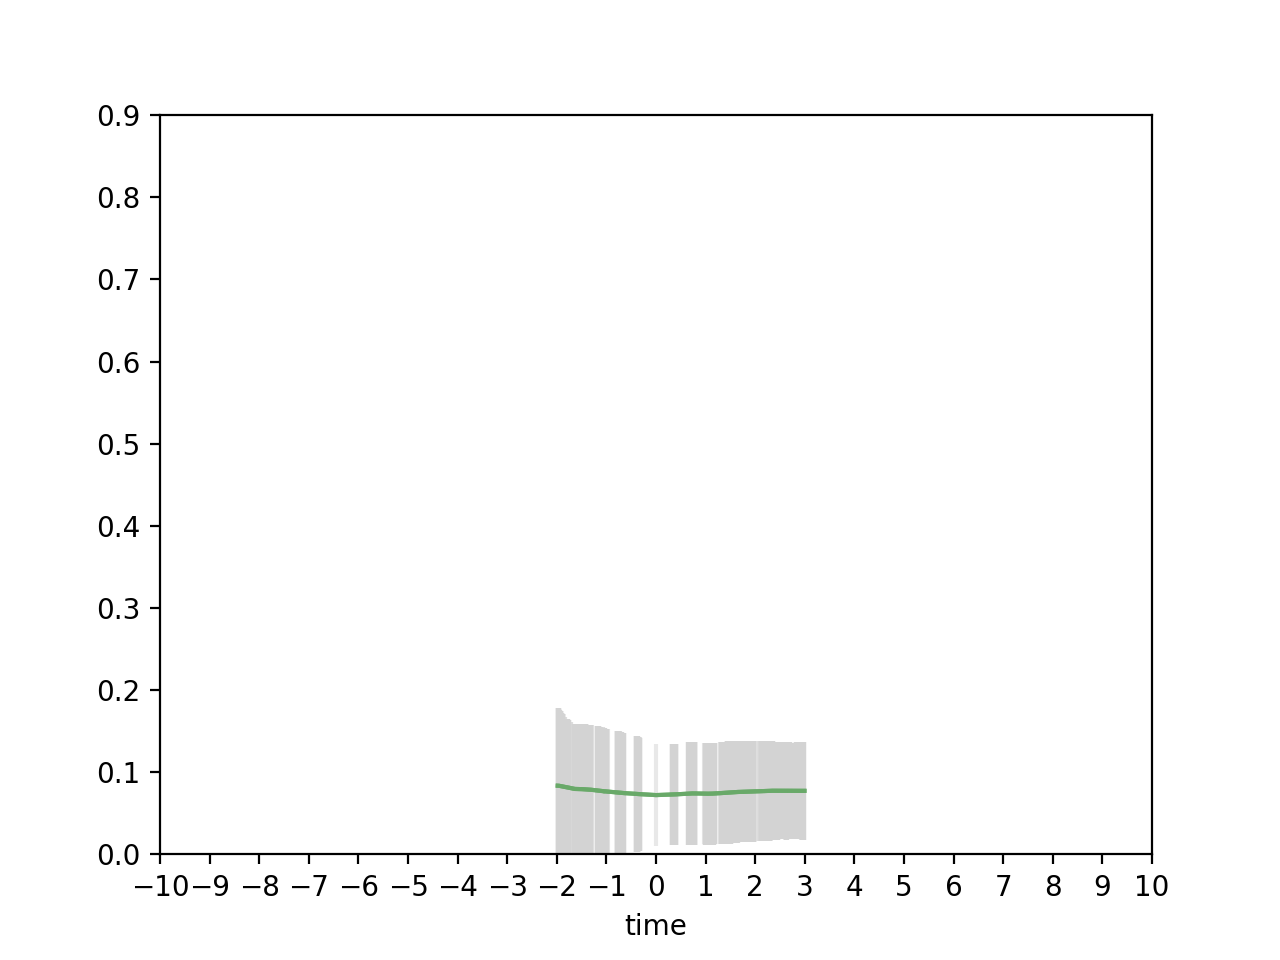

In [54]:
# Average and stddev, min, max, sem for same_behavior_transition events
all_Strans_avg_df = int_all_Strans_df.mean(axis=1) # Interpolated data used
all_Strans_min_df = int_all_Strans_df.min(axis=1)
all_Strans_max_df = int_all_Strans_df.max(axis=1)
# Standard deviation (distribution)
all_Strans_std_df = int_all_Strans_df.std(axis = 1)
#standard error of mean
all_Strans_sem_df = int_all_Strans_df.sem(axis = 1)
#wrong zur haelfte: Want to have avg per celltyp over time point, 
#and not avg over all cells per timepoint

# Plotting for multi-events (same_behavioral_transition)
# If a dataframe with NANs is plotted (raw-data = non interpolated), use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=1, fov=(-10, 10, 0.0, 0.9), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

# Plot all cells from all_df, aligned at zero for event_start, specified in Cell_Trace_Config.
#sub1 = fig.add_subplot(111) #211
#all_trans_df.plot(ax=sub1, marker = '*', label = ctc.cell_type)
#aligned_layout_plot(sub1)

sub2 = fig.add_subplot(111) #212
all_Strans_avg_df.plot(ax=sub2, color = 'g', label = ctc.cell_type) #use interpolated df to calculate average...
#all_Strans_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#all_Strans_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
all_Strans_avg_df.plot.line(yerr=all_Strans_std_df, ax=sub2, color = 'lightgrey', alpha = 0.5)
#all_Strans_avg_df.plot.line(yerr=all_Strans_sem_df, ax=sub2, color = 'grey', alpha = 0.1)
aligned_layout_plot(sub2)

In [55]:
# Using class Transitiongrouper to group cell_type/pattern or both
# ToDo 
# cellpattern_groups not working
# ToDo
# Calculate sem, std-dev

# Input dataframe from behavioral transitions (Post-, Same-, Triple-Transition)
grouper = TransitionGrouper(int_all_Strans_df)

# Function to calculate the average cell/pattern_groups depending on regex
def average_grouping(grouping):
    df = grouping[list(grouping)[0]][1]
    average_df = pd.DataFrame(index=df.index)
    
    for group_pattern, df in grouping.values():
        average_col = df.mean(axis=1)
        average_df[group_pattern] = average_col

    return average_df

    
cell_groups = grouper.group_cells()
cell_averages = average_grouping(cell_groups)
print(cell_averages.head())

pattern_groups = grouper.group_patterns()
pattern_average = average_grouping(pattern_groups) 
print(pattern_average.head())

#cellpattern_groups = grouper.group_cellpattern()
#cellpattern_averages = average_grouping(cellpattern_groups) #not working:(, error


        basin_.*
time            
-1.981  0.083635
-1.980  0.083635
-1.980  0.083635
-1.980  0.083635
-1.979  0.083635
          .*_A1L  .*_A1L.1  .*_A1L.2  .*_A1L.3    .*_A1R  .*_A1R.1  .*_A1R.2  \
time                                                                           
-1.981  0.088121  0.089858   0.07549  0.087223  0.085023  0.101711  0.067629   
-1.980  0.088121  0.089858   0.07549  0.087223  0.085023  0.101711  0.067629   
-1.980  0.088121  0.089858   0.07549  0.087223  0.085023  0.101711  0.067629   
-1.980  0.088121  0.089858   0.07549  0.087223  0.085023  0.101711  0.067629   
-1.979  0.088121  0.089858   0.07549  0.087223  0.085023  0.101711  0.067629   

        .*_A1R.3    .*_A2L  .*_A2L.1  ...  .*_T2R.1  .*_T2R.2    .*_T3L  \
time                                  ...                                 
-1.981  0.236731  0.080747   0.07928  ...  0.070168  0.070626  0.076436   
-1.980  0.236731  0.080747   0.07928  ...  0.070168  0.070626  0.076436   
-1.980  0.236731  0.

<IPython.core.display.Javascript object>


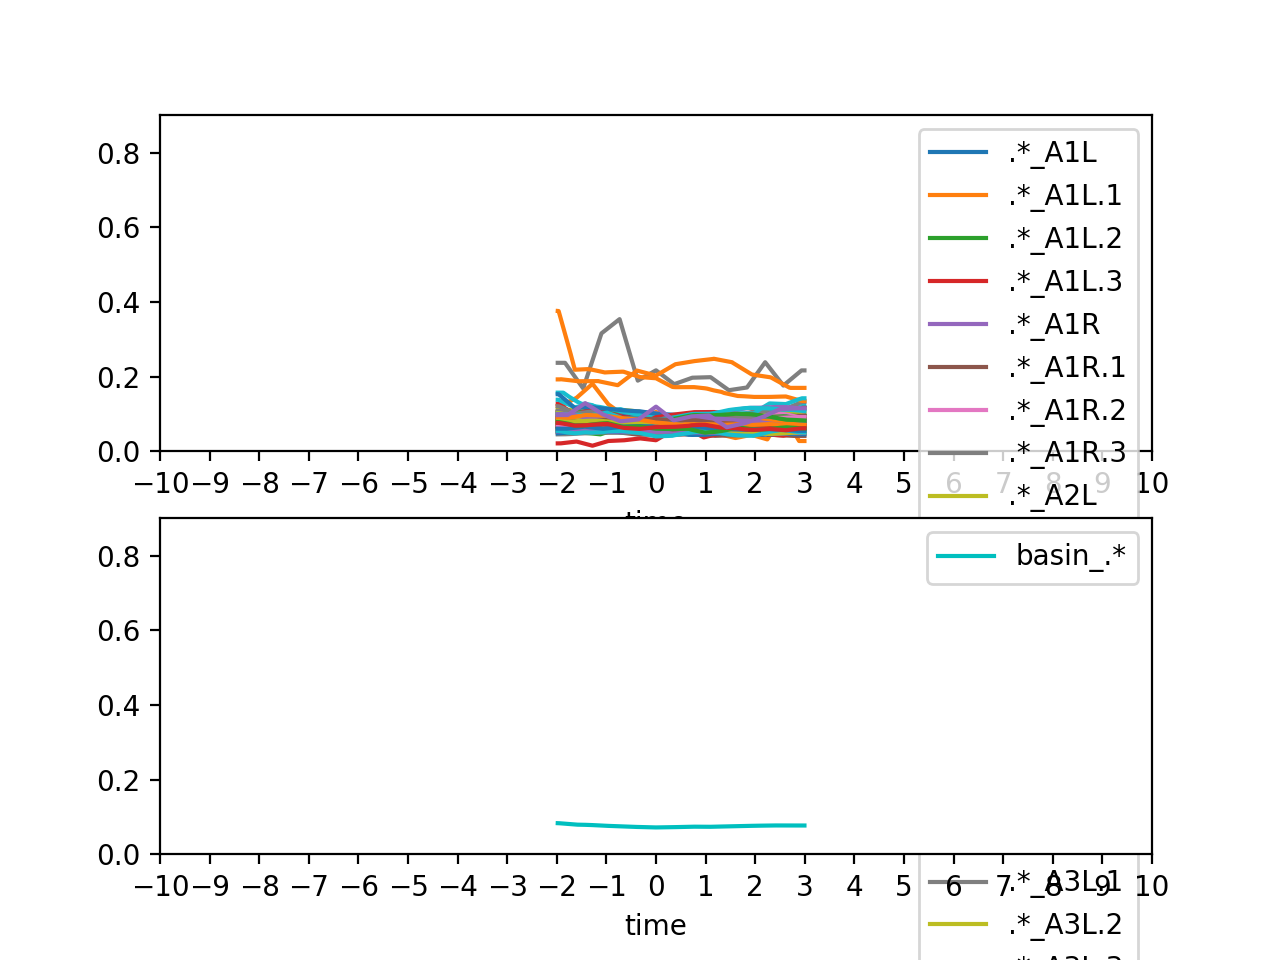

In [56]:
# Plot average, std-dev from Transition grouper

def aligned_layout_plot(plot, tick_spacing=1, fov=(-10, 10, 0.0, 0.9), legend=True): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

sub1 = fig.add_subplot(211)
pattern_average.plot(ax=sub1)
aligned_layout_plot(sub1)

sub2 = fig.add_subplot(212)
cell_averages.plot(ax=sub2, color = 'c', label = 'A00c')
aligned_layout_plot(sub2)

In [ ]:
# 

'''
# Average and stddev, min, max, sem for same_behavior_transition events
all_Strans_avg_df = int_all_Strans_df.mean(axis=1) # Interpolated data used
all_Strans_min_df = int_all_Strans_df.min(axis=1)
all_Strans_max_df = int_all_Strans_df.max(axis=1)
# Standard deviation (distribution)
all_Strans_std_df = int_all_Strans_df.std(axis = 1)
#standard error of mean
all_Strans_sem_df = int_all_Strans_df.sem(axis = 1)
#wrong zur haelfte: Want to have avg per celltyp over time point, 
#and not avg over all cells per timepoint

# Plotting for multi-events (same_behavioral_transition)
# If a dataframe with NANs is plotted (raw-data = non interpolated), use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=1, fov=(-10, 10, 0.0, 0.9), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

# Plot all cells from all_df, aligned at zero for event_start, specified in Cell_Trace_Config.
#sub1 = fig.add_subplot(111) #211
#all_trans_df.plot(ax=sub1, marker = '*', label = ctc.cell_type)
#aligned_layout_plot(sub1)

sub2 = fig.add_subplot(111) #212
all_Strans_avg_df.plot(ax=sub2, color = 'g', label = ctc.cell_type) #use interpolated df to calculate average...
#all_Strans_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#all_Strans_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
all_Strans_avg_df.plot.line(yerr=all_Strans_std_df, ax=sub2, color = 'lightgrey', alpha = 0.5)
#all_Strans_avg_df.plot.line(yerr=all_Strans_sem_df, ax=sub2, color = 'grey', alpha = 0.1)
aligned_layout_plot(sub2)

'''

In [ ]:
# Duration of each behavior (min, max, avg)

desired_behavior = "hunch"
all_durations = []
sample_ids = []
start_times = []
end_times = []
for sample_id, sample_df in tqdm(sample_data.items()):
    if any(["bw" in column for column in sample_df.columns]):
        for i, row in sample_df.iterrows():
            if row["{}_start".format(desired_behavior)]:  
                start_times.append(row["time"])
                sample_ids.append(sample_id)
            if row["{}_end".format(desired_behavior)]: 
                end_time = row["time"]
                end_times.append(row["time"])
        assert len(end_times) == len(start_times), "{} start times vs {} end times on sample {}".format(len(start_times), len(end_times), sample_id)
all_durations = [end - start for start, end in zip(start_times, end_times)]
durations_with_sample_id = list(zip(sample_ids, all_durations))

# Test if behavior.csv is correct
for t, sample_id, start_time, end_time in zip(all_durations, sample_ids, start_times, end_times):
    if t > 200:
        print(sample_id, start_time, end_time)

#print(durations_with_sample_id[0:10])

#print(all_durations)       
#print(len(all_durations))
avg_duration = np.mean(all_durations)
max_duration = np.max(all_durations)
min_duration = np.min(all_durations)

print(avg_duration)
#print(max_duration)
#print(min_duration)

# Histogram
plt.hist(all_durations, bins=5, alpha=0.5)
plt.show()

#print(list(filter(lambda x: x> 10, all_durations))) 





In [ ]:
#####

In [ ]:
# Neuronal activity during a certain behavior

cell = "candidate"
align_to_start = True

# For same_behavior_transition events get event_time and use cell_trace_config to filter by celltype and pattern.
# The results are merged and interpolated.
cell_trans_configs = []
all_trans_events = []

for sample_id, start_time, end_time in zip(sample_ids, start_times, end_times):
    if align_to_start:
        cell_trans_configs.append(CellTransConfig(sample_id, cell, 
                                              start_time))
    else:
        cell_trans_configs.append(CellTransConfig(sample_id, cell, 
                                              end_time))
        

# Extract for specific time window and align several events. 
# Define timepoints pre and post an event (event_df). 
# This works for single sample or multiple samples aligned 
# Note: In cell_subset_df, time was set to index, because for the previous avg calculation 
# Add index and time = column

# Set the window range left and right from the event
left_half_window_size = 1.0 #in seconds
right_half_window_size = 3.0

# trans_df defined in pargraph before 
windows = []
n_behavior = 0

for ctc in tqdm(cell_trans_configs):
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
    
    # Extract columns matching our cell type and the optional filter pattern.
    # Pandas' filter() operations works on columns for DataFrames by default.
    
    # Skip this if no cell
    # Apply filter regex 
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    #print(cell_subset_df)
    
    # Don't apply filter regex, but take all cells from lm_data
    #cell_subset_df =  lm_data.get(ctc.sample_id)#Get subset of cells 
    #cell_subset_df.reset_index(inplace = True, drop = True) # Add index and time = column
    #print(cell_subset_df)
    
    n_behavior += 1
    window_start = ctc.event_time - left_half_window_size
    window_end = ctc.event_time + right_half_window_size
        
    # Get subset of rows between window_start and window_end       
    trans = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]

    # Normalizing the data to align on beginning of selected
    # behavior (event_df = Zero) by substracting events in window
    # around start of event of interest from start of event interest.
    # Note: using ":" in event.loc[] will select "all rows" in our window.
    #trans.loc[:, 'time'] = trans['time'] - row['time']
    trans.loc[:, 'time'] = trans['time'] - ctc.event_time  
    
    # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
    trans.rename(lambda x: '{}_{}_{}'.format(ctc.sample_id, x, n_behavior), axis = 'columns', inplace = True) 

    # Rename time column to time
    trans.rename(columns={ trans.columns[0]: 'time' }, inplace = True) 
    all_trans_events.append(trans) # Append a list with all event
#print(all_trans_events)   
        
        
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_trans_df = all_trans_events.pop(0)
for right_df in all_trans_events:
    all_trans_df = pd.merge_ordered(all_trans_df, right_df, on="time", how="outer")

# Resets the index as time and drops time column
all_trans_df.index = all_trans_df["time"]
del all_trans_df["time"]        
#print(all_trans_df)

# Index intepolation (linear interpolatione not on all_df, because index [=time] is not eaqually distributed)
int_all_trans_df = all_trans_df.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')
#print(int_all_trans_df)


In [ ]:
# Average and stddev, min, max, sem for same_behavior_transition events
all_trans_avg_df = int_all_trans_df.mean(axis=1) # Interpolated data used
all_trans_min_df = int_all_trans_df.min(axis=1)
all_trans_max_df = int_all_trans_df.max(axis=1)
# Standard deviation (distribution)
all_trans_std_df = int_all_trans_df.std(axis = 1)
#standard error of mean
all_trans_sem_df = int_all_trans_df.sem(axis = 1)
#wrong zur haelfte: Want to have avg per celltyp over time point, 
#and not avg over all cells per timepoint

# Plotting for multi-events (same_behavioral_transition)
# If a dataframe with NANs is plotted (raw-data = non interpolated), use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=1, fov=(-2, 10, 0.0, 1.2), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

# Plot all cells from all_df, aligned at zero for event_start, specified in Cell_Trace_Config.
#sub1 = fig.add_subplot(111) #211
#all_trans_df.plot(ax=sub1, marker = '*', label = ctc.cell_type)
#aligned_layout_plot(sub1)

sub2 = fig.add_subplot(111) #212
all_trans_avg_df.plot(ax=sub2, color = 'c', label = ctc.cell_type) #use interpolated df to calculate average...
#all_Strans_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#all_Strans_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
all_trans_avg_df.plot.line(yerr=all_trans_std_df, ax=sub2, color = 'grey', alpha = 0.5)
#all_Strans_avg_df.plot.line(yerr=all_Strans_sem_df, ax=sub2, color = 'grey', alpha = 0.1)
aligned_layout_plot(sub2)

In [ ]:
# Test if sum of left and right turns = turns
#for sample_id, sample_df in tqdm(sample_data.items()):
    #print(sample_id, sum(sample_df['turn_start']), sum(sample_df['left turn_start']), sum(sample_df['right turn_start']))
#    if sum(sample_df['turn_start']) != (sum(sample_df['left turn_start']) + sum(sample_df['right turn_start'])):
#        print(sample_id)

In [ ]:
# Test number of behavior
#alle = []
#for sample_id, sample_df in tqdm(sample_data.items()):
    #print(sum(sample_df['turn_start']))
#    alle.append(sum(sample_df['HP_start']))
    
#print(sum(alle))

In [ ]:
# ToDo 

# Will

# NR
# cell activity during a certain behavior
#Compare the duration/gap with old histgrams
    # Basin per hemisegment (wait until identity, single hemisekments are too variable for my taste)
    # confidence intervall (keep in mind)
# cross-correlation
# correlation matrix cell-cell before and after 
# non-negative matrix factorization (for dynamic and weighting) ?? ich weiss ja nicht


In [ ]:
# Correlation Matrix 
# Extract for data int_all_Ptrans where second_event_start - second event ends
#I cheat with window size (its actually a good idea:)
#legend would be nice
# header of matrix 
# muss average pro cell_id haben sonst plottet er fur jedes sample/transition extra

# Define time window for pretransition_start




# Define time window for posttransition_start


plt.matshow(int_all_Ptrans_df.corr())
plt.show()

correlation = np.corrcoef(int_all_Ptrans_df) #data(cell,time)
print(correlation)

Testing 

In [ ]:
#print(list(event_df)) #prints header
#rounded time is only visual, I still get several 'same' tp
#sample_df.round({'time' : 1})
   # Round time on 1 or 2nd decimal
    # the df.round({'time' : 1}) doesn't work if to many decimals
    #decimals = 2    
    #timestamp_df['time'] = timestamp_df['time'].apply(lambda x: round(x, decimals))

In [ ]:
'''
# Test
def test_find_behavior_before():
    data_columns = ['time', 'bw_start', 'bw_end', 'bw_overlap', 'fw_start', 'fw_end', 'fw_overlap', 'turn_start', 'turn_end', 'turn_overlap']
    data = [
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [3, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [4, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [5, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    ]
    toy_df = pd.DataFrame(data, columns = data_columns)
    
    behavior_transitions = [
        #PostBehaviorTransition('17-08-26L1-cl', 'turn', 'bw', 11),
        #PostBehaviorTransition('17-08-26L2-cl', 'stim', 'fw', 3),
        #PostBehaviorTransition('17-08-26L5-cl', 'stim', 'fw', 3),
        PostBehaviorTransition('na', 'fw', 'bw', 5)
    ]
    
    found_transitions = []
    for bt in behavior_transitions:
        sample_df = toy_df
        if sample_df is None:
            raise ValueError('No data found for sample {}'.format(bt.sample_id))
        transitions = find_behavior_before(bt.sample_id, sample_df, bt.event, bt.post_event, bt.max_delay)

        if transitions:
            found_transitions.append(transitions)


    print(len(found_transitions)) #number of data sets not the actual stim
    print(len(transitions)) 
    print(found_transitions)
    
test_find_behavior_before()
'''

In [ ]:
d = {'A' : [3.2, np.nan, np.nan, 5, np.nan, np.nan],
     'B' : [np.nan, 4.1, np.nan, np.nan, 6.2, np.nan], 
     'C' : [np.nan, np.nan, 1.1, np.nan, np.nan, 2.5]}
df = pd.DataFrame(data=d)
print(df)


int_df_linear = df.interpolate(method = 'linear', inplace = False)
print(int_df_linear)

int_df_index = df.interpolate(method='index', inplace=False)
print(int_df_index)
#u = df['T'].unique

# Resets the index as time and drops time column
#df.index = df["T"]
#del df["T"] 

#df.fillna(value=None, method='ffill', axis=None, inplace=False, limit=None, downcast=None) # not what I want
#df.interpolate(method='linear', axis=0, limit=None,
#                      inplace=False, limit_direction='forward', limit_area=None, downcast=None) 


# print out only rows where in'T' are duplicates
#df[df.duplicated(subset= ['T'], keep=False)]

    
    
#np.nanmean(j, axis=0)
#    for j in df.loc[df["T"]== value]:
#        np.nanmean(j, axis=0)


#df.mean(axis=1, skipna=None)
#print(df)


In [ ]:
t = {'T' : [1,2, 3, 4, 5, 6, 7, 8], 'A' : [3.2, 5, 5.5, 5.3, 9, 8, 8, 3],
     'B' : [4.1, 6.2, 6.0, 6.2, 8, 1, 1.5, 3.7], 
     'C' : [1.1, 2.5, 2.3, 1.2, 0.9, 1.1, 1.8, 1.7]}
df1 = pd.DataFrame(data=d)
df1

d = {'A' : [3.2, 5, 5.5, 5.3, 9, 8, 8, 3],
     'B' : [4.1, 6.2, 6.0, 6.2, 8, 1, 1.5, 3.7], 
     'C' : [1.1, 2.5, 2.3, 1.2, 0.9, 1.1, 1.8, 1.7]}
df2 = pd.DataFrame(data=d)
print(df2)


In [ ]:
# Interpolation 
# inplace  = False, since we want to keep the data sets with raw data as well

# Linear Interpolation: According to documentation, 
# because it assums the index is equally spaced.
# ‘Index’, ‘values’: use the actual numerical values of the index.

int_df2 = df2.interpolate(method = 'index', inplace = False)
print(int_df2)

#Note: First 5 values = NAN!!??!! (Method?)

#intpol_all_df = all_df.interpolate(method='index', inplace=False)
#print(intpol_all_df)
ls = [2, 1.2, 3, 8.2]
#for i in ls:
    #print(i)
a =int_df2.loc[int_df2['C'].isin(ls)]
print(a)
# find row where C = 1.2 #isin
#a =int_df2.loc[df['C'].isin(1.2)]
#a =int_df2.loc[int_df2['C'] == 1.2]

#print(a)

In [ ]:
# Data anlysis - TODO

# Dataprocessing
# For the next step, we try two methods two normalize the data and get the timestamps 
# in synchrony between the different samples/events (1.Interpolation of some kind, 2. Binning,
# 3) fitting curve)
               
# Interpolation 
# inplace  = False, since we want to keep the data sets with raw data as well

# Linear Interpolation: According to documentation it is not correct to use, 
# because it assums the index is equally spaced.

# ‘Index’, ‘values’: use the actual numerical values of the index.

#Note: First 5 values = NAN!!??!!

#intpol_all_df = all_df.interpolate(method='index', inplace=False)
#print(intpol_all_df)

In [ ]:
'''
#test
def test_find_behavior_next():
    data_columns = ['time', 'bw_start', 'bw_end', 'bw_overlap', 'fw_start', 'fw_end', 'fw_overlap', 'turn_start', 'turn_end', 'turn_overlap']
    data = [
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [3, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [4, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [5, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [6, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [7, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [9, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [10, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [11, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [12, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [13, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [14, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ]
    toy_df = pd.DataFrame(data, columns = data_columns)

    behavior_transitions = [
    SamePairBehaviorTransition('na', 'bw', 'bw', 12)]


    found_transitions = []
    for bt in behavior_transitions:
        sample_df = toy_df
        if sample_df is None:
            raise ValueError('No data found for sample {}'.format(bt.sample_id))
        transitions = find_behavior_next(bt.sample_id, sample_df, bt.pre_event, bt.event, bt.max_delay)

        if transitions:
            found_transitions.append(transitions)

    print(len(transitions))
    print(len(found_transitions))
    print(found_transitions)
    
test_find_behavior_next()
'''

In [ ]:
x = [1,2,3,4,5]
a,b,c,*d = x
print(d)